In [188]:
## ML pipeline
## DataSource -> Pre-Process -> InputData
## TrainingModule -> Model
## EvaluationData -> Pre-Process -> Model -> Result

## Detection pipeline
## [path] --> read -- [image, label] -->  crop -- [image, label]-->  hsv_hog --> [(hsv, hog), label] --> TrainingModule 

In [189]:
class FileSource:
    def __init__(self, src_dir, pattern, input_type='dir'):
        self.src_dir = src_dir
        self.pattern = pattern
        if input_type == 'file':
            self.files = [os.path.join(self.src_dir, pattern)]
        else:    
            self.files = glob.glob(os.path.join(self.src_dir + '/**/' + self.pattern), recursive=True)
        self.current = 0
        self.offset = 0
    
    def __iter__(self):
        return self
    
    def next(self):
        if self.current == len(self.files):
            raise StopIteration()
        else:
            file = self.files[self.current]
            self.current = self.current + 1
            return file
    
    def has_next(self):
        return self.current < len(self.files)
    
class PickledSource:
    
    def __init__(self, input_path):
        self.done = False
        self.input_path = input_path
    
    def __iter__(self):
        return self
    
    def next(self):
        if self.done:
            raise StopIteration()
        else:
            with open(self.input_path, 'rb') as inp:
                result = pickle.load(inp)
                self.done = True
                return result
    
    def has_next(self):
        return not self.done
    
class EmptySource:
    
    def __init__(self):
        self.done = True

    def __iter__(self):
        return self
    
    def next(self):
        return None
    
    def has_next(self):
        return False

In [190]:
import os
import glob
import matplotlib.pyplot as plt

BASE_DIR = '/Users/raman/work/car_nd/self_driving_nano/p5_vehicle_detection'
TEST_INPUT_DIR = os.path.join(BASE_DIR, 'test_images')
INPUT_DIR_CARS = os.path.join(BASE_DIR, 'training_data', 'vehicles')
INPUT_DIR_OTHERS = os.path.join(BASE_DIR, 'training_data', 'non-vehicles')
pix_per_cell = 8
cell_per_block = 2
orient = 9
spatial_bining_size = (32, 32)
nbins=32
image_shape = (760, 1280)


def display_image(image):
    for image in pipeline.process():
        plt.imshow(image)
        plt.show()

plt.close()


In [191]:
from abc import ABCMeta,abstractmethod
import pickle

class Operation(metaclass=ABCMeta):
    
    def __init__(self):
        pass
        
    @abstractmethod
    def operate(self, context, inp):
        pass

In [192]:
class SourceOperator:
    
    def __init__(self, data_source):
        self.data_source = data_source

    def next(self):
        while self.data_source.has_next():
            inp = self.data_source.next()
            yield inp
            
    def eval(self, input_data):
        return input_data        
        
class ProcessingOperator:
    
    def __init__(self, src, operation, itemize):
        self.src = src.next()
        self.operation = operation
        self.itemize = itemize
        
    def next(self):
        for inp in self.src:
            out =  self.operation.operate(inp)
            if self.itemize:
                for v in out:
                    yield v
            else:
                yield out
    
    def eval(self, input):
        return self.operation.operate(input)
            
class CompositeOperator:
    
    def __init__(self, src, operations, itemize):
        self.src = src.next()
        self.operations = operations
        self.itemize = itemize
        
    def next(self):
        for inp in self.src:
            outputs = []
            for op in self.operations:
                out =  op.operate(inp)
                if self.itemize is True:
                    for o in out:
                        outputs.append(o)
                else:
                    outputs.append(out)
            yield np.concatenate(outputs)
    
    def eval(self, input):
        for inp in self.src:
            outputs = []
            for op in self.operations:
                out =  op.operate(inp)
                outputs.append(out)
            return np.concatenate(outputs) 
        
class OutputOperator:
    
    def __init__(self, src, writer):
        self.src = src.next()
        self.writer = writer
        
    def next(self):
        all_inputs = []
        count = 0
        for inp in self.src:
            all_inputs.append(inp)
            count = count + 1
            if count % 500 == 0:
                print("{} items processed".format(count))
        print("{} processed".format(count))
        yield self.writer.operate(all_inputs)
        
    def eval(self, input):
        return self.writer.operate(input)
    

In [193]:
class Pipeline:
    
    def __init__(self):
        self.operations = []
        self.last = SourceOperator(EmptySource())
    
    def add_source(self, source):
        self.source = SourceOperator(source)
        self.operations.append(self.source)
        self.last = self.source
    
    def add(self, process, itemize = False):
        operator = ProcessingOperator(self.last, process, itemize)
        self.operations.append(operator)
        self.last = operator
        self.itemize = itemize
    
    def add_output(self, output):
        operator = OutputOperator(self.last, output)
        self.output_operator = operator
        self.operations.append(operator)
        self.last = operator
    
    def add_composite(self, operations, itemize = False):
        operator = CompositeOperator(self.last, operations, itemize)
        self.operations.append(operator)
        self.last = operator
        
    def process(self):
        for output in  self.output_operator.next():
            yield output           
            
    def consume(self, input):
        data = input
        for op in self.operations:
            data = op.operation.operate(data)
        return data
        
def execute_pipeline(pipeline, name=""):
    output = []
    for out in pipeline.process():
        output.append(out)
    return output
        

In [204]:
import cv2
import numpy as np

class ColorSpaceConverter(Operation):
    
    def __init__(self, color_space):
        self.color_space = color_space
        
    def operate(self, image):
        if self.color_space != 'BGR':
            if self.color_space == 'RGB':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            if self.color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
            elif self.color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)
            elif self.color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
            elif self.color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            elif self.color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        else: feature_image = np.copy(image) 
        return feature_image

class Reader(Operation):
    
    def __init__(self):
        pass
        
    def operate(self, input_path):
        return cv2.imread(input_path)
       
    
class Resizer(Operation):
    
    def __init__(self, size):
        self.size = size
   
    def operate(self, image):
        return cv2.resize(image, self.size)

    
class ImageDataAmplifier(Operation):
    
    def __init__(self):
        self.angle = 5
        
    def operate(self, image):
        flipped = self.flip(image)
        rotated = self.rotate(image)
        return [image, flipped, rotated]
        
    def flip(self, image):
        return np.fliplr(image)
    
    def rotate(self, image):
        x,y,c = image.shape
        image_center = tuple(np.array(image.shape)/2)
        rot_mat = cv2.getRotationMatrix2D((y/2, x/2),self.angle,1.0)
        rotated = cv2.warpAffine(image, rot_mat, (y,x),flags=cv2.INTER_NEAREST, borderMode=cv2.BORDER_REPLICATE)
        return rotated

    
class SpatialBinning(Operation):
    
    def __init__(self, size, color_space='RGB'):
        self.color_space = color_space
        self.size = size
    
    def operate(self, image):        
        # Convert image to new color space (if specified)
        if self.color_space != 'RGB':
            if self.color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif self.color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif self.color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif self.color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif self.color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)             
        # Use cv2.resize().ravel() to create the feature vector
        return cv2.resize(feature_image, self.size).ravel() 
     

class ChannelHistogram(Operation):

    def __init__(self, nbins=32, bins_range=(0, 256)):
        self.nbins = nbins
        self.bins_range = bins_range
    
    def operate(self, image): 
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=self.nbins, range=self.bins_range)
        channel2_hist = np.histogram(img[:,:,1], bins=self.nbins, range=self.bins_range)
        channel3_hist = np.histogram(img[:,:,2], bins=self.nbins, range=self.bins_range)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features


from skimage.feature import hog
class HOG(Operation):
    
    def __init__(self, orient, pix_per_cell, cell_per_block, hog_channel):
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel
    
    def operate(self, image):
        if self.hog_channel == 'ALL':
            hog_features = []
            for channel in range(image.shape[2]):
                channel_feature = hog(image[:,:,channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                      cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                      feature_vector=self.feature_vector)
                hog_features.append(channel_feature)
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = hog(image[:,:,self.hog_channel], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                      cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                      feature_vector=self.feature_vector)
            hog_features = hog_features.ravel()
        return hog_features

from sklearn.preprocessing import StandardScaler
class StandardScaling:

    def __init__(self):
        pass
    
    def operate(self, feature_list):
        X = np.vstack(feature_list).astype(np.float64)
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)
        return scaled_X

class PickleSerializer(Operation):
    
    def __init__(self, output_path):
        self.output_path = output_path
    
    def operate(self, inp):
        with open(self.output_path, 'wb') as output:
            print("writing {} items to {}".format(len(inp), self.output_path))
            pickle.dump(inp, output)

class ImageDisplay(Operation):
    
    def __init__(self):
        pass
    
    def operate(self, image):
        plt.imshow(image.squeeze())
        plt.show()
        

        class SlidingWindows(Operation):
    
    def __init__(self, window_size = (64, 64), overlap = (0.5, 0.5), varying_size = False):
        self.window_size = window_size
        self.varying_size = varying_size
        self.overlap = overlap
        self.bounding_boxes = None
        
    def operate(self, image):
        if self.bounding_boxes is None:
            h, w, _ = image.shape
            self.bounding_boxes = self.get_bounding_boxes((0, w), (np.int(h/2), h), self.window_size, self.overlap)
        return (image, self.bounding_boxes)
   
    def get_bounding_boxes(self, x_start_stop, y_start_stop, xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
        # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] is None or  x_start_stop[1] is None:
            x_start_stop = [0, img.shape[1]]
        if y_start_stop[0] is None or  y_start_stop[1] is None:
            y_start_stop = [0, img.shape[0]]

        # Compute the span of the region to be searched    
        # Compute the number of pixels per step in x/y
        n_pixels_per_step = (np.int(xy_window[0]*xy_overlap[0]), np.int(xy_window[1]*xy_overlap[1]))
        # Compute the number of windows in x/y
        n_windows_x = np.int(1 + (x_start_stop[1] - x_start_stop[0] - xy_window[0])/xy_window[0])
        n_windows_y = np.int(1 + (y_start_stop[1] - y_start_stop[0] - xy_window[1])/xy_window[1])
        # Initialize a list to append window positions to
        window_list = []
        for x_window_pos in range(x_start_stop[0], x_start_stop[1]-n_pixels_per_step[0], n_pixels_per_step[0]):
            for y_window_pos in range(y_start_stop[0], y_start_stop[1] - xy_window[1], n_pixels_per_step[1]):
                top_left = (x_window_pos, y_window_pos)
                bottom_right = (x_window_pos + xy_window[0], y_window_pos + xy_window[1])
                box = (top_left, bottom_right)
                window_list.append(box)

        return  window_list 

    
# resize area of interest
class CropScale(Operation):
    
    def __init__(self, ystart, ystop, scale):
        self.ystart = ystart
        self.ystop = ystop
        self.scale = scale
        
    def operate(self, image):
        # extract the image of interest (lower half)
        img_of_interest = image[self.ystart:self.ystop,:,:]
        resized = img_of_interest
        if self.scale != 1:
            imshape = img_of_interest.shape
            resized = cv2.resize(img_of_interest, (np.int(imshape[1]/self.scale), np.int(imshape[0]/self.scale)))
        return (image, resized)
    
    
class Hog(Operation):
    
    def __init__(self, orient, pix_per_cell, cell_per_block):
        self.hog_op = HOG(orient, pix_per_cell, cell_per_block, hog_channel='ALL')
        
    def operate(self, input):
        orig_image = input[0]
        cropped = input[1]
        
        # Compute individual channel HOG features for the entire image
        hog_features  = self.hog_op.operate(cropped) # all channels, feature_vector = False
        return (orig_image, cropped, hog_features)
               
class PatternDetector(Operation):
    
    def __init__(self, model, windows, x_scaler):
        self.model = model
        self.windows = windows
        self.channel_hist_op = ChannelHistogram()
        self.spatial_op = SpatialBinning(spatial_bining_size, color_space = 'YCrCb')
        self.x_scaler = x_scaler

    def operate(self, input):
        orig_image    = input[0]
        cropped_image = input[1]
        hog_features  = input[2]
       
        orig_height, orig_width, _ = orig_image.shape
        crop_height, crop_width, _ = cropped_image.shape
        y_adjust = orig_height - crop_height
        ytop = 0
        car_windows = []
        for window in self.windows: # windows were made on original image
            # Extract the image patch
            top_left, bottom_right = (window[0], window[1])
            
            patch_y_start = top_left[1] - y_adjust
            patch_y_end   = bottom_right[1] - y_adjust
            patch_x_start = top_left[0]
            patch_x_end   = bottom_right[0]
            
            patch_of_interest = cropped_image[patch_y_start : patch_y_end, patch_x_start : patch_x_end, :]
            subimg = cv2.resize(patch_of_interest, (64,64))
            
            # subsample hog
            hog_feat1 = hog_features[0][patch_y_start : patch_y_end, patch_x_start : patch_x_end, :].ravel() 
            hog_feat2 = hog_features[1][patch_y_start : patch_y_end, patch_x_start : patch_x_end, :].ravel() 
            hog_feat3 = hog_features[2][patch_y_start : patch_y_end, patch_x_start : patch_x_end, :].ravel() 
            hog_patch_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            print("# of hog features {}".format(len(hog_features)))
            
            # Get color features
            hist_features = self.channel_hist_op.operate(subimg)
            spatial_features = self.spatial_op.operate(subimg)
            print("# of hist    features {}".format(len(hist_features)))
            print("# of spatial features {}".format(len(spatial_features)))
            
            # Scale features
            test_features = self.x_scaler.transform(np.hstack((spatial_features, hist_features, hog_patch_features)))
                                      #.reshape(1, -1))                  
            
            # Make a prediction
            test_prediction = self.model.predict(test_features)
            if test_prediction == 1:
                car_windows.append(window)
        return (orig_image, car_windows)
    
class DrawWindows(Operation):
    
    def __init__(self):
        pass
    
    def operate(self, input):
        image = input[0]
        windows = input[1]
        draw_image = np.copy(image)
        for window in windows:
            top_left = window[0]
            right_bottom = window[1]
            cv2.rectangle(draw_image,(top_left[0], top_left[1]),(right_bottom[0],right_bottom[1]),(0,0,255),6) 
        return draw_image
        
class FindCars(Operation):
    
    def __init__(self, ystart, ystop, scale, pix_per_cell, cell_per_block, orient, svc, spatial_size, hist_bins):
        self.ystart = ystart
        self.ystop = ystop
        self.scale = scale
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.orient = orient
        self.svc = svc
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
    
    @staticmethod
    def convert_color(img, conv='RGB2YCrCb'):
        if conv == 'RGB2YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        if conv == 'BGR2YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        if conv == 'RGB2LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

    @staticmethod
    def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=orient, 
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), 
                                      transform_sqrt=False, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(img, orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), 
                           transform_sqrt=False, 
                           visualise=vis, feature_vector=feature_vec)
            return features
    
    @staticmethod
    def bin_spatial(img, size=(32, 32)):
        color1 = cv2.resize(img[:,:,0], size).ravel()
        color2 = cv2.resize(img[:,:,1], size).ravel()
        color3 = cv2.resize(img[:,:,2], size).ravel()
        return np.hstack((color1, color2, color3))

    @staticmethod
    def color_hist(img, nbins=32):    #bins_range=(0, 256)
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features
    
    def operate(self, img):
        draw_img = np.copy(img)
        img = img.astype(np.float32)/255
        print("{} {}".format(self.ystart, self.ystop))
        img_tosearch = img[self.ystart:self.ystop,:,:]
        ctrans_tosearch = FindCars.convert_color(img_tosearch, conv='RGB2YCrCb')
        if self.scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/self.scale), np.int(imshape[0]/self.scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // self.pix_per_cell) - self.cell_per_block + 1
        nyblocks = (ch1.shape[0] // self.pix_per_cell) - self.cell_per_block + 1 
        nfeat_per_block = self.orient*self.cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // self.pix_per_cell) - self.cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = FindCars.get_hog_features(ch1, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
        hog2 = FindCars.get_hog_features(ch2, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
        hog3 = FindCars.get_hog_features(ch3, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*self.pix_per_cell
                ytop = ypos*self.pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = FindCars.bin_spatial(subimg, size=self.spatial_size)
                hist_features = FindCars.color_hist(subimg, nbins=self.hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = self.svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*self.scale)
                    ytop_draw = np.int(ytop*self.scale)
                    win_draw = np.int(window*self.scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

        return draw_img
        

In [195]:
from matplotlib import pyplot as plt

target_resize = (64, 64)
pix_per_cell = 8
cell_per_block = 2
orient = 9
spatial_bining_size = (32, 32)
output_file_cars = 'feature_vectors_cars_7.p'
output_file_others = 'feature_vectors_non_cars_7.p'

def extract_feature_vectors(source, output_file):
    pipeline = Pipeline()
    pipeline.add_source(source)
    pipeline.add(Reader())
#   pipeline.add(ImageDataAmplifier(), itemize = True)
    pipeline.add(Resizer(target_resize))
    pipeline.add(ColorSpaceConverter('YCrCb'))
    pipeline.add_composite([ChannelHistogram(), SpatialBinning(spatial_bining_size),
                                                               HOG(orient, cell_per_block, pix_per_cell, 'ALL')])
    pipeline.add(StandardScaling())
    pipeline.add_output(PickleSerializer (output_file))
    return pipeline

source_cars     = FileSource(INPUT_DIR_CARS, "*.png")
pipeline = extract_feature_vectors(source_cars, output_file_cars)
execute_pipeline(pipeline, 'car vectors')

source_non_cars = FileSource(INPUT_DIR_OTHERS, "*.png")
pipeline = extract_feature_vectors(source_non_cars, output_file_others)
execute_pipeline(pipeline, 'non-car vectors')

/Users/raman/anaconda/envs/carnd/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


500 items processed
1000 items processed
1500 items processed
2000 items processed
2500 items processed
3000 items processed
3500 items processed
4000 items processed
4500 items processed
5000 items processed
5500 items processed
6000 items processed
6500 items processed
7000 items processed
7500 items processed
8000 items processed
8500 items processed
8792 processed
writing 8792 items to feature_vectors_cars_7.p
500 items processed
1000 items processed
1500 items processed
2000 items processed
2500 items processed
3000 items processed
3500 items processed
4000 items processed
4500 items processed
5000 items processed
5500 items processed
6000 items processed
6500 items processed
7000 items processed
7500 items processed
8000 items processed
8500 items processed
8968 processed
writing 8968 items to feature_vectors_non_cars_7.p


[None]

In [197]:
output_file_cars = 'feature_vectors_cars_7.p'
output_file_others = 'feature_vectors_non_cars_7.p'

with open(output_file_cars, 'rb') as inp:
    car_features = pickle.load(inp)

with open(output_file_others, 'rb') as inp:
    non_car_features = pickle.load(inp)

print("cars has {} items".format(len(car_features)))
print("non_cars has {} items".format(len(non_car_features)))

car_features = [cp.flatten() for cp in car_features]
non_car_features = [cp.flatten() for cp in non_car_features]

print (len(car_features))

cars has 8792 items
non_cars has 8968 items
8792


In [198]:
from sklearn.preprocessing import StandardScaler
# Create an array stack of feature vectors
X = np.vstack((car_features, non_car_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))

from sklearn.cross_validation import train_test_split
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.1, random_state=rand_state)

from sklearn.svm import LinearSVC
# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Train the SVC
svc.fit(X_train, y_train)
print('Test Accuracy of SVC = ', svc.score(X_test, y_test))


Test Accuracy of SVC =  0.974099099099


In [199]:

model_file = 'svc_classifier.p'
with open(model_file, 'wb') as out:
    pickle.dump(svc, out)


In [200]:
with open(model_file, 'rb') as inp:
    model = pickle.load(inp)

print('Test Accuracy of SVC = ', model.score(X_test, y_test))    

Test Accuracy of SVC =  0.974099099099


((0, 360), (64, 424))
(720, 1280, 3)
360 720


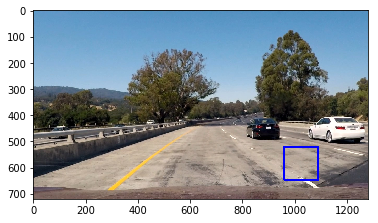

In [214]:
test_image = '/Users/raman/work/car_nd/self_driving_nano/p5_vehicle_detection/test_images/test1.jpg'
image = cv2.imread(test_image)

orient = 9
pix_per_cell = 8
cell_per_block = 2
h,w,_ = image.shape
ystart = np.int(h/2)
ystop = h
scale = 2
spatial_binning_size = (32, 32)
nbins=32


_,windows = SlidingWindows().operate(image)
print(windows[0])
print(image.shape)
pipeline = Pipeline()
pipeline.add(ColorSpaceConverter('RGB'))
pipeline.add(FindCars(ystart, ystop, scale, pix_per_cell, cell_per_block, orient, model, spatial_binning_size, nbins))
output = pipeline.consume(image)
ImageDisplay().operate(output)


In [207]:
%pylab inline
## define video processing pipeline
# initialize variable-size bounding windows
# extract window images
# compute HOG + HSV
# image -> (image, boxes) -> (image, features(HSV, HOG), boxes) -> (image, boxes, car_no_car)-> image
pipeline = Pipeline()
pipeline.add(ColorSpaceConverter('YCrCb'))
pipeline.add(FindCars(ystart, ystop, scale, pix_per_cell, cell_per_block, orient, model, spatial_binning_size, nbins))

from moviepy.editor import VideoFileClip
output = 'project_5_output.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(0,5)
output_clip = clip1.fl_image(pipeline.consume)
%time output_clip.write_videofile(output, audio=False)

Populating the interactive namespace from numpy and matplotlib
360 720
[MoviePy] >>>> Building video project_5_output.mp4
[MoviePy] Writing video project_5_output.mp4



  0%|          | 0/1261 [00:00<?, ?it/s]

360 720



  0%|          | 1/1261 [00:01<22:51,  1.09s/it]

360 720



  0%|          | 2/1261 [00:02<22:31,  1.07s/it]

360 720



  0%|          | 3/1261 [00:03<22:22,  1.07s/it]

360 720



  0%|          | 4/1261 [00:04<22:09,  1.06s/it]

360 720



  0%|          | 5/1261 [00:05<21:57,  1.05s/it]

360 720



  0%|          | 6/1261 [00:06<21:49,  1.04s/it]

360 720



  1%|          | 7/1261 [00:07<21:56,  1.05s/it]

360 720



  1%|          | 8/1261 [00:08<22:06,  1.06s/it]

360 720



  1%|          | 9/1261 [00:09<22:11,  1.06s/it]

360 720



  1%|          | 10/1261 [00:10<21:59,  1.06s/it]

360 720



  1%|          | 11/1261 [00:11<22:10,  1.06s/it]

360 720



  1%|          | 12/1261 [00:12<22:18,  1.07s/it]

360 720



  1%|          | 13/1261 [00:13<22:12,  1.07s/it]

360 720



  1%|          | 14/1261 [00:14<22:00,  1.06s/it]

360 720



  1%|          | 15/1261 [00:15<21:59,  1.06s/it]

360 720



  1%|▏         | 16/1261 [00:16<21:57,  1.06s/it]

360 720



  1%|▏         | 17/1261 [00:17<21:51,  1.05s/it]

360 720



  1%|▏         | 18/1261 [00:18<21:41,  1.05s/it]

360 720



  2%|▏         | 19/1261 [00:20<22:23,  1.08s/it]

360 720



  2%|▏         | 20/1261 [00:21<22:20,  1.08s/it]

360 720



  2%|▏         | 21/1261 [00:22<21:52,  1.06s/it]

360 720



  2%|▏         | 22/1261 [00:23<21:43,  1.05s/it]

360 720



  2%|▏         | 23/1261 [00:24<21:37,  1.05s/it]

360 720



  2%|▏         | 24/1261 [00:25<21:49,  1.06s/it]

360 720



  2%|▏         | 25/1261 [00:26<22:26,  1.09s/it]

360 720



  2%|▏         | 26/1261 [00:27<23:12,  1.13s/it]

360 720



  2%|▏         | 27/1261 [00:29<24:51,  1.21s/it]

360 720



  2%|▏         | 28/1261 [00:30<24:46,  1.21s/it]

360 720



  2%|▏         | 29/1261 [00:31<23:46,  1.16s/it]

360 720



  2%|▏         | 30/1261 [00:32<23:11,  1.13s/it]

360 720



  2%|▏         | 31/1261 [00:33<22:56,  1.12s/it]

360 720



  3%|▎         | 32/1261 [00:34<23:08,  1.13s/it]

360 720



  3%|▎         | 33/1261 [00:35<23:20,  1.14s/it]

360 720



  3%|▎         | 34/1261 [00:37<23:31,  1.15s/it]

360 720



  3%|▎         | 35/1261 [00:38<23:36,  1.16s/it]

360 720



  3%|▎         | 36/1261 [00:39<24:27,  1.20s/it]

360 720



  3%|▎         | 37/1261 [00:40<24:12,  1.19s/it]

360 720



  3%|▎         | 38/1261 [00:41<24:14,  1.19s/it]

360 720



  3%|▎         | 39/1261 [00:42<23:14,  1.14s/it]

360 720



  3%|▎         | 40/1261 [00:43<22:33,  1.11s/it]

360 720



  3%|▎         | 41/1261 [00:45<22:21,  1.10s/it]

360 720



  3%|▎         | 42/1261 [00:46<22:07,  1.09s/it]

360 720



  3%|▎         | 43/1261 [00:47<22:06,  1.09s/it]

360 720



  3%|▎         | 44/1261 [00:48<22:55,  1.13s/it]

360 720



  4%|▎         | 45/1261 [00:49<23:42,  1.17s/it]

360 720



  4%|▎         | 46/1261 [00:50<24:01,  1.19s/it]

360 720



  4%|▎         | 47/1261 [00:52<26:10,  1.29s/it]

360 720



  4%|▍         | 48/1261 [00:54<30:09,  1.49s/it]

360 720



  4%|▍         | 49/1261 [00:56<31:43,  1.57s/it]

360 720



  4%|▍         | 50/1261 [00:57<31:10,  1.54s/it]

360 720



  4%|▍         | 51/1261 [00:59<30:38,  1.52s/it]

360 720



  4%|▍         | 52/1261 [01:00<30:39,  1.52s/it]

360 720



  4%|▍         | 53/1261 [01:02<31:47,  1.58s/it]

360 720



  4%|▍         | 54/1261 [01:03<31:50,  1.58s/it]

360 720



  4%|▍         | 55/1261 [01:05<30:19,  1.51s/it]

360 720



  4%|▍         | 56/1261 [01:06<27:54,  1.39s/it]

360 720



  5%|▍         | 57/1261 [01:07<25:57,  1.29s/it]

360 720



  5%|▍         | 58/1261 [01:08<24:23,  1.22s/it]

360 720



  5%|▍         | 59/1261 [01:09<23:25,  1.17s/it]

360 720



  5%|▍         | 60/1261 [01:10<22:37,  1.13s/it]

360 720



  5%|▍         | 61/1261 [01:11<22:08,  1.11s/it]

360 720



  5%|▍         | 62/1261 [01:12<21:30,  1.08s/it]

360 720



  5%|▍         | 63/1261 [01:13<21:29,  1.08s/it]

360 720



  5%|▌         | 64/1261 [01:14<21:27,  1.08s/it]

360 720



  5%|▌         | 65/1261 [01:15<21:20,  1.07s/it]

360 720



  5%|▌         | 66/1261 [01:16<21:23,  1.07s/it]

360 720



  5%|▌         | 67/1261 [01:17<21:06,  1.06s/it]

360 720



  5%|▌         | 68/1261 [01:18<20:55,  1.05s/it]

360 720



  5%|▌         | 69/1261 [01:19<20:37,  1.04s/it]

360 720



  6%|▌         | 70/1261 [01:21<21:06,  1.06s/it]

360 720



  6%|▌         | 71/1261 [01:22<20:49,  1.05s/it]

360 720



  6%|▌         | 72/1261 [01:23<20:47,  1.05s/it]

360 720



  6%|▌         | 73/1261 [01:24<20:37,  1.04s/it]

360 720



  6%|▌         | 74/1261 [01:25<20:28,  1.04s/it]

360 720



  6%|▌         | 75/1261 [01:26<20:29,  1.04s/it]

360 720



  6%|▌         | 76/1261 [01:27<20:38,  1.05s/it]

360 720



  6%|▌         | 77/1261 [01:28<20:41,  1.05s/it]

360 720



  6%|▌         | 78/1261 [01:29<20:29,  1.04s/it]

360 720



  6%|▋         | 79/1261 [01:30<20:43,  1.05s/it]

360 720



  6%|▋         | 80/1261 [01:31<20:44,  1.05s/it]

360 720



  6%|▋         | 81/1261 [01:32<20:23,  1.04s/it]

360 720



  7%|▋         | 82/1261 [01:33<20:39,  1.05s/it]

360 720



  7%|▋         | 83/1261 [01:34<20:47,  1.06s/it]

360 720



  7%|▋         | 84/1261 [01:35<21:08,  1.08s/it]

360 720



  7%|▋         | 85/1261 [01:36<21:18,  1.09s/it]

360 720



  7%|▋         | 86/1261 [01:37<21:03,  1.08s/it]

360 720



  7%|▋         | 87/1261 [01:39<20:54,  1.07s/it]

360 720



  7%|▋         | 88/1261 [01:40<20:27,  1.05s/it]

360 720



  7%|▋         | 89/1261 [01:41<20:10,  1.03s/it]

360 720



  7%|▋         | 90/1261 [01:42<19:56,  1.02s/it]

360 720



  7%|▋         | 91/1261 [01:43<19:51,  1.02s/it]

360 720



  7%|▋         | 92/1261 [01:44<20:53,  1.07s/it]

360 720



  7%|▋         | 93/1261 [01:45<21:09,  1.09s/it]

360 720



  7%|▋         | 94/1261 [01:46<20:42,  1.06s/it]

360 720



  8%|▊         | 95/1261 [01:47<20:15,  1.04s/it]

360 720



  8%|▊         | 96/1261 [01:48<20:14,  1.04s/it]

360 720



  8%|▊         | 97/1261 [01:49<20:21,  1.05s/it]

360 720



  8%|▊         | 98/1261 [01:50<20:38,  1.07s/it]

360 720



  8%|▊         | 99/1261 [01:51<20:24,  1.05s/it]

360 720



  8%|▊         | 100/1261 [01:52<20:09,  1.04s/it]

360 720



  8%|▊         | 101/1261 [01:53<20:14,  1.05s/it]

360 720



  8%|▊         | 102/1261 [01:54<20:05,  1.04s/it]

360 720



  8%|▊         | 103/1261 [01:55<19:55,  1.03s/it]

360 720



  8%|▊         | 104/1261 [01:56<19:45,  1.03s/it]

360 720



  8%|▊         | 105/1261 [01:57<20:56,  1.09s/it]

360 720



  8%|▊         | 106/1261 [01:59<21:54,  1.14s/it]

360 720



  8%|▊         | 107/1261 [02:00<22:35,  1.17s/it]

360 720



  9%|▊         | 108/1261 [02:01<23:01,  1.20s/it]

360 720



  9%|▊         | 109/1261 [02:02<23:09,  1.21s/it]

360 720



  9%|▊         | 110/1261 [02:04<22:52,  1.19s/it]

360 720



  9%|▉         | 111/1261 [02:05<22:59,  1.20s/it]

360 720



  9%|▉         | 112/1261 [02:06<22:06,  1.15s/it]

360 720



  9%|▉         | 113/1261 [02:07<21:16,  1.11s/it]

360 720



  9%|▉         | 114/1261 [02:08<21:04,  1.10s/it]

360 720



  9%|▉         | 115/1261 [02:09<20:44,  1.09s/it]

360 720



  9%|▉         | 116/1261 [02:10<20:32,  1.08s/it]

360 720



  9%|▉         | 117/1261 [02:11<20:15,  1.06s/it]

360 720



  9%|▉         | 118/1261 [02:12<20:08,  1.06s/it]

360 720



  9%|▉         | 119/1261 [02:13<20:16,  1.07s/it]

360 720



 10%|▉         | 120/1261 [02:14<20:31,  1.08s/it]

360 720



 10%|▉         | 121/1261 [02:16<21:35,  1.14s/it]

360 720



 10%|▉         | 122/1261 [02:17<22:14,  1.17s/it]

360 720



 10%|▉         | 123/1261 [02:18<23:37,  1.25s/it]

360 720



 10%|▉         | 124/1261 [02:19<23:26,  1.24s/it]

360 720



 10%|▉         | 125/1261 [02:21<22:50,  1.21s/it]

360 720



 10%|▉         | 126/1261 [02:22<22:30,  1.19s/it]

360 720



 10%|█         | 127/1261 [02:23<22:43,  1.20s/it]

360 720



 10%|█         | 128/1261 [02:24<22:52,  1.21s/it]

360 720



 10%|█         | 129/1261 [02:25<22:51,  1.21s/it]

360 720



 10%|█         | 130/1261 [02:27<22:14,  1.18s/it]

360 720



 10%|█         | 131/1261 [02:28<21:51,  1.16s/it]

360 720



 10%|█         | 132/1261 [02:29<21:33,  1.15s/it]

360 720



 11%|█         | 133/1261 [02:30<21:44,  1.16s/it]

360 720



 11%|█         | 134/1261 [02:31<21:13,  1.13s/it]

360 720



 11%|█         | 135/1261 [02:32<20:52,  1.11s/it]

360 720



 11%|█         | 136/1261 [02:33<20:26,  1.09s/it]

360 720



 11%|█         | 137/1261 [02:34<20:05,  1.07s/it]

360 720



 11%|█         | 138/1261 [02:35<19:45,  1.06s/it]

360 720



 11%|█         | 139/1261 [02:36<19:36,  1.05s/it]

360 720



 11%|█         | 140/1261 [02:37<19:30,  1.04s/it]

360 720



 11%|█         | 141/1261 [02:38<19:24,  1.04s/it]

360 720



 11%|█▏        | 142/1261 [02:39<19:26,  1.04s/it]

360 720



 11%|█▏        | 143/1261 [02:40<19:27,  1.04s/it]

360 720



 11%|█▏        | 144/1261 [02:41<19:23,  1.04s/it]

360 720



 11%|█▏        | 145/1261 [02:42<19:24,  1.04s/it]

360 720



 12%|█▏        | 146/1261 [02:44<19:36,  1.05s/it]

360 720



 12%|█▏        | 147/1261 [02:45<19:29,  1.05s/it]

360 720



 12%|█▏        | 148/1261 [02:46<19:27,  1.05s/it]

360 720



 12%|█▏        | 149/1261 [02:47<19:25,  1.05s/it]

360 720



 12%|█▏        | 150/1261 [02:48<19:17,  1.04s/it]

360 720



 12%|█▏        | 151/1261 [02:49<19:17,  1.04s/it]

360 720



 12%|█▏        | 152/1261 [02:50<19:10,  1.04s/it]

360 720



 12%|█▏        | 153/1261 [02:51<19:02,  1.03s/it]

360 720



 12%|█▏        | 154/1261 [02:52<19:09,  1.04s/it]

360 720



 12%|█▏        | 155/1261 [02:53<19:22,  1.05s/it]

360 720



 12%|█▏        | 156/1261 [02:54<19:16,  1.05s/it]

360 720



 12%|█▏        | 157/1261 [02:55<19:21,  1.05s/it]

360 720



 13%|█▎        | 158/1261 [02:56<19:07,  1.04s/it]

360 720



 13%|█▎        | 159/1261 [02:57<19:04,  1.04s/it]

360 720



 13%|█▎        | 160/1261 [02:58<19:10,  1.05s/it]

360 720



 13%|█▎        | 161/1261 [02:59<19:06,  1.04s/it]

360 720



 13%|█▎        | 162/1261 [03:00<19:04,  1.04s/it]

360 720



 13%|█▎        | 163/1261 [03:01<19:13,  1.05s/it]

360 720



 13%|█▎        | 164/1261 [03:02<19:02,  1.04s/it]

360 720



 13%|█▎        | 165/1261 [03:03<18:59,  1.04s/it]

360 720



 13%|█▎        | 166/1261 [03:04<18:52,  1.03s/it]

360 720



 13%|█▎        | 167/1261 [03:05<18:54,  1.04s/it]

360 720



 13%|█▎        | 168/1261 [03:06<18:54,  1.04s/it]

360 720



 13%|█▎        | 169/1261 [03:07<18:52,  1.04s/it]

360 720



 13%|█▎        | 170/1261 [03:09<18:49,  1.04s/it]

360 720



 14%|█▎        | 171/1261 [03:10<18:48,  1.04s/it]

360 720



 14%|█▎        | 172/1261 [03:11<18:41,  1.03s/it]

360 720



 14%|█▎        | 173/1261 [03:12<18:48,  1.04s/it]

360 720



 14%|█▍        | 174/1261 [03:13<18:46,  1.04s/it]

360 720



 14%|█▍        | 175/1261 [03:14<18:55,  1.05s/it]

360 720



 14%|█▍        | 176/1261 [03:15<18:48,  1.04s/it]

360 720



 14%|█▍        | 177/1261 [03:16<18:49,  1.04s/it]

360 720



 14%|█▍        | 178/1261 [03:17<19:00,  1.05s/it]

360 720



 14%|█▍        | 179/1261 [03:18<18:49,  1.04s/it]

360 720



 14%|█▍        | 180/1261 [03:19<18:49,  1.04s/it]

360 720



 14%|█▍        | 181/1261 [03:20<18:48,  1.04s/it]

360 720



 14%|█▍        | 182/1261 [03:21<18:44,  1.04s/it]

360 720



 15%|█▍        | 183/1261 [03:22<19:01,  1.06s/it]

360 720



 15%|█▍        | 184/1261 [03:23<19:01,  1.06s/it]

360 720



 15%|█▍        | 185/1261 [03:24<18:54,  1.05s/it]

360 720



 15%|█▍        | 186/1261 [03:25<18:52,  1.05s/it]

360 720



 15%|█▍        | 187/1261 [03:26<18:42,  1.05s/it]

360 720



 15%|█▍        | 188/1261 [03:27<18:38,  1.04s/it]

360 720



 15%|█▍        | 189/1261 [03:28<18:37,  1.04s/it]

360 720



 15%|█▌        | 190/1261 [03:29<18:35,  1.04s/it]

360 720



 15%|█▌        | 191/1261 [03:30<18:24,  1.03s/it]

360 720



 15%|█▌        | 192/1261 [03:31<18:22,  1.03s/it]

360 720



 15%|█▌        | 193/1261 [03:32<18:10,  1.02s/it]

360 720



 15%|█▌        | 194/1261 [03:34<18:18,  1.03s/it]

360 720



 15%|█▌        | 195/1261 [03:35<18:25,  1.04s/it]

360 720



 16%|█▌        | 196/1261 [03:36<18:16,  1.03s/it]

360 720



 16%|█▌        | 197/1261 [03:37<18:22,  1.04s/it]

360 720



 16%|█▌        | 198/1261 [03:38<18:17,  1.03s/it]

360 720



 16%|█▌        | 199/1261 [03:39<18:24,  1.04s/it]

360 720



 16%|█▌        | 200/1261 [03:40<18:20,  1.04s/it]

360 720



 16%|█▌        | 201/1261 [03:41<18:07,  1.03s/it]

360 720



 16%|█▌        | 202/1261 [03:42<18:12,  1.03s/it]

360 720



 16%|█▌        | 203/1261 [03:43<18:06,  1.03s/it]

360 720



 16%|█▌        | 204/1261 [03:44<18:05,  1.03s/it]

360 720



 16%|█▋        | 205/1261 [03:45<18:10,  1.03s/it]

360 720



 16%|█▋        | 206/1261 [03:46<18:06,  1.03s/it]

360 720



 16%|█▋        | 207/1261 [03:47<18:01,  1.03s/it]

360 720



 16%|█▋        | 208/1261 [03:48<17:54,  1.02s/it]

360 720



 17%|█▋        | 209/1261 [03:49<18:03,  1.03s/it]

360 720



 17%|█▋        | 210/1261 [03:50<18:06,  1.03s/it]

360 720



 17%|█▋        | 211/1261 [03:51<18:03,  1.03s/it]

360 720



 17%|█▋        | 212/1261 [03:52<18:00,  1.03s/it]

360 720



 17%|█▋        | 213/1261 [03:53<18:04,  1.03s/it]

360 720



 17%|█▋        | 214/1261 [03:54<17:57,  1.03s/it]

360 720



 17%|█▋        | 215/1261 [03:55<17:56,  1.03s/it]

360 720



 17%|█▋        | 216/1261 [03:56<17:59,  1.03s/it]

360 720



 17%|█▋        | 217/1261 [03:57<18:04,  1.04s/it]

360 720



 17%|█▋        | 218/1261 [03:58<17:55,  1.03s/it]

360 720



 17%|█▋        | 219/1261 [03:59<17:59,  1.04s/it]

360 720



 17%|█▋        | 220/1261 [04:00<17:58,  1.04s/it]

360 720



 18%|█▊        | 221/1261 [04:01<18:00,  1.04s/it]

360 720



 18%|█▊        | 222/1261 [04:02<17:54,  1.03s/it]

360 720



 18%|█▊        | 223/1261 [04:03<18:01,  1.04s/it]

360 720



 18%|█▊        | 224/1261 [04:05<18:08,  1.05s/it]

360 720



 18%|█▊        | 225/1261 [04:06<18:07,  1.05s/it]

360 720



 18%|█▊        | 226/1261 [04:07<18:04,  1.05s/it]

360 720



 18%|█▊        | 227/1261 [04:08<18:00,  1.04s/it]

360 720



 18%|█▊        | 228/1261 [04:09<17:50,  1.04s/it]

360 720



 18%|█▊        | 229/1261 [04:10<17:46,  1.03s/it]

360 720



 18%|█▊        | 230/1261 [04:11<17:48,  1.04s/it]

360 720



 18%|█▊        | 231/1261 [04:12<17:49,  1.04s/it]

360 720



 18%|█▊        | 232/1261 [04:13<17:54,  1.04s/it]

360 720



 18%|█▊        | 233/1261 [04:14<17:59,  1.05s/it]

360 720



 19%|█▊        | 234/1261 [04:15<17:50,  1.04s/it]

360 720



 19%|█▊        | 235/1261 [04:16<17:47,  1.04s/it]

360 720



 19%|█▊        | 236/1261 [04:17<17:37,  1.03s/it]

360 720



 19%|█▉        | 237/1261 [04:18<17:34,  1.03s/it]

360 720



 19%|█▉        | 238/1261 [04:19<17:40,  1.04s/it]

360 720



 19%|█▉        | 239/1261 [04:20<17:44,  1.04s/it]

360 720



 19%|█▉        | 240/1261 [04:21<17:42,  1.04s/it]

360 720



 19%|█▉        | 241/1261 [04:22<17:38,  1.04s/it]

360 720



 19%|█▉        | 242/1261 [04:23<17:35,  1.04s/it]

360 720



 19%|█▉        | 243/1261 [04:24<17:38,  1.04s/it]

360 720



 19%|█▉        | 244/1261 [04:25<17:33,  1.04s/it]

360 720



 19%|█▉        | 245/1261 [04:26<17:30,  1.03s/it]

360 720



 20%|█▉        | 246/1261 [04:27<17:34,  1.04s/it]

360 720



 20%|█▉        | 247/1261 [04:28<17:33,  1.04s/it]

360 720



 20%|█▉        | 248/1261 [04:30<17:43,  1.05s/it]

360 720



 20%|█▉        | 249/1261 [04:31<17:42,  1.05s/it]

360 720



 20%|█▉        | 250/1261 [04:32<17:39,  1.05s/it]

360 720



 20%|█▉        | 251/1261 [04:33<17:29,  1.04s/it]

360 720



 20%|█▉        | 252/1261 [04:34<17:31,  1.04s/it]

360 720



 20%|██        | 253/1261 [04:35<17:27,  1.04s/it]

360 720



 20%|██        | 254/1261 [04:36<17:25,  1.04s/it]

360 720



 20%|██        | 255/1261 [04:37<17:17,  1.03s/it]

360 720



 20%|██        | 256/1261 [04:38<17:05,  1.02s/it]

360 720



 20%|██        | 257/1261 [04:39<17:04,  1.02s/it]

360 720



 20%|██        | 258/1261 [04:40<17:04,  1.02s/it]

360 720



 21%|██        | 259/1261 [04:41<17:08,  1.03s/it]

360 720



 21%|██        | 260/1261 [04:42<17:07,  1.03s/it]

360 720



 21%|██        | 261/1261 [04:43<17:17,  1.04s/it]

360 720



 21%|██        | 262/1261 [04:44<17:18,  1.04s/it]

360 720



 21%|██        | 263/1261 [04:45<17:17,  1.04s/it]

360 720



 21%|██        | 264/1261 [04:46<17:17,  1.04s/it]

360 720



 21%|██        | 265/1261 [04:47<17:18,  1.04s/it]

360 720



 21%|██        | 266/1261 [04:48<17:07,  1.03s/it]

360 720



 21%|██        | 267/1261 [04:49<17:08,  1.03s/it]

360 720



 21%|██▏       | 268/1261 [04:50<17:03,  1.03s/it]

360 720



 21%|██▏       | 269/1261 [04:51<17:05,  1.03s/it]

360 720



 21%|██▏       | 270/1261 [04:52<17:22,  1.05s/it]

360 720



 21%|██▏       | 271/1261 [04:53<17:29,  1.06s/it]

360 720



 22%|██▏       | 272/1261 [04:54<17:32,  1.06s/it]

360 720



 22%|██▏       | 273/1261 [04:55<17:22,  1.06s/it]

360 720



 22%|██▏       | 274/1261 [04:57<17:21,  1.06s/it]

360 720



 22%|██▏       | 275/1261 [04:58<17:26,  1.06s/it]

360 720



 22%|██▏       | 276/1261 [04:59<17:16,  1.05s/it]

360 720



 22%|██▏       | 277/1261 [05:00<17:10,  1.05s/it]

360 720



 22%|██▏       | 278/1261 [05:01<17:00,  1.04s/it]

360 720



 22%|██▏       | 279/1261 [05:02<17:01,  1.04s/it]

360 720



 22%|██▏       | 280/1261 [05:03<16:59,  1.04s/it]

360 720



 22%|██▏       | 281/1261 [05:04<16:56,  1.04s/it]

360 720



 22%|██▏       | 282/1261 [05:05<16:51,  1.03s/it]

360 720



 22%|██▏       | 283/1261 [05:06<16:49,  1.03s/it]

360 720



 23%|██▎       | 284/1261 [05:07<16:47,  1.03s/it]

360 720



 23%|██▎       | 285/1261 [05:08<16:47,  1.03s/it]

360 720



 23%|██▎       | 286/1261 [05:09<16:46,  1.03s/it]

360 720



 23%|██▎       | 287/1261 [05:10<16:41,  1.03s/it]

360 720



 23%|██▎       | 288/1261 [05:11<16:40,  1.03s/it]

360 720



 23%|██▎       | 289/1261 [05:12<16:46,  1.04s/it]

360 720



 23%|██▎       | 290/1261 [05:13<16:48,  1.04s/it]

360 720



 23%|██▎       | 291/1261 [05:14<16:50,  1.04s/it]

360 720



 23%|██▎       | 292/1261 [05:15<17:10,  1.06s/it]

360 720



 23%|██▎       | 293/1261 [05:16<17:06,  1.06s/it]

360 720



 23%|██▎       | 294/1261 [05:17<16:52,  1.05s/it]

360 720



 23%|██▎       | 295/1261 [05:18<16:43,  1.04s/it]

360 720



 23%|██▎       | 296/1261 [05:19<16:48,  1.04s/it]

360 720



 24%|██▎       | 297/1261 [05:20<16:43,  1.04s/it]

360 720



 24%|██▎       | 298/1261 [05:22<16:43,  1.04s/it]

360 720



 24%|██▎       | 299/1261 [05:23<16:45,  1.04s/it]

360 720



 24%|██▍       | 300/1261 [05:24<16:38,  1.04s/it]

360 720



 24%|██▍       | 301/1261 [05:25<16:35,  1.04s/it]

360 720



 24%|██▍       | 302/1261 [05:26<16:34,  1.04s/it]

360 720



 24%|██▍       | 303/1261 [05:27<16:44,  1.05s/it]

360 720



 24%|██▍       | 304/1261 [05:28<16:42,  1.05s/it]

360 720



 24%|██▍       | 305/1261 [05:29<16:43,  1.05s/it]

360 720



 24%|██▍       | 306/1261 [05:30<16:46,  1.05s/it]

360 720



 24%|██▍       | 307/1261 [05:31<16:40,  1.05s/it]

360 720



 24%|██▍       | 308/1261 [05:32<16:27,  1.04s/it]

360 720



 25%|██▍       | 309/1261 [05:33<16:22,  1.03s/it]

360 720



 25%|██▍       | 310/1261 [05:34<16:23,  1.03s/it]

360 720



 25%|██▍       | 311/1261 [05:35<16:18,  1.03s/it]

360 720



 25%|██▍       | 312/1261 [05:36<16:14,  1.03s/it]

360 720



 25%|██▍       | 313/1261 [05:37<16:11,  1.02s/it]

360 720



 25%|██▍       | 314/1261 [05:38<16:13,  1.03s/it]

360 720



 25%|██▍       | 315/1261 [05:39<16:19,  1.04s/it]

360 720



 25%|██▌       | 316/1261 [05:40<16:17,  1.03s/it]

360 720



 25%|██▌       | 317/1261 [05:41<16:21,  1.04s/it]

360 720



 25%|██▌       | 318/1261 [05:42<16:22,  1.04s/it]

360 720



 25%|██▌       | 319/1261 [05:43<16:17,  1.04s/it]

360 720



 25%|██▌       | 320/1261 [05:44<16:17,  1.04s/it]

360 720



 25%|██▌       | 321/1261 [05:45<16:18,  1.04s/it]

360 720



 26%|██▌       | 322/1261 [05:46<16:17,  1.04s/it]

360 720



 26%|██▌       | 323/1261 [05:47<16:15,  1.04s/it]

360 720



 26%|██▌       | 324/1261 [05:49<16:13,  1.04s/it]

360 720



 26%|██▌       | 325/1261 [05:50<16:14,  1.04s/it]

360 720



 26%|██▌       | 326/1261 [05:51<16:09,  1.04s/it]

360 720



 26%|██▌       | 327/1261 [05:52<16:01,  1.03s/it]

360 720



 26%|██▌       | 328/1261 [05:53<16:05,  1.03s/it]

360 720



 26%|██▌       | 329/1261 [05:54<16:11,  1.04s/it]

360 720



 26%|██▌       | 330/1261 [05:55<16:06,  1.04s/it]

360 720



 26%|██▌       | 331/1261 [05:56<16:09,  1.04s/it]

360 720



 26%|██▋       | 332/1261 [05:57<16:00,  1.03s/it]

360 720



 26%|██▋       | 333/1261 [05:58<15:59,  1.03s/it]

360 720



 26%|██▋       | 334/1261 [05:59<15:54,  1.03s/it]

360 720



 27%|██▋       | 335/1261 [06:00<15:45,  1.02s/it]

360 720



 27%|██▋       | 336/1261 [06:01<15:51,  1.03s/it]

360 720



 27%|██▋       | 337/1261 [06:02<15:51,  1.03s/it]

360 720



 27%|██▋       | 338/1261 [06:03<15:53,  1.03s/it]

360 720



 27%|██▋       | 339/1261 [06:04<15:47,  1.03s/it]

360 720



 27%|██▋       | 340/1261 [06:05<15:48,  1.03s/it]

360 720



 27%|██▋       | 341/1261 [06:06<15:43,  1.03s/it]

360 720



 27%|██▋       | 342/1261 [06:07<15:45,  1.03s/it]

360 720



 27%|██▋       | 343/1261 [06:08<15:49,  1.03s/it]

360 720



 27%|██▋       | 344/1261 [06:09<15:50,  1.04s/it]

360 720



 27%|██▋       | 345/1261 [06:10<15:44,  1.03s/it]

360 720



 27%|██▋       | 346/1261 [06:11<15:44,  1.03s/it]

360 720



 28%|██▊       | 347/1261 [06:12<15:59,  1.05s/it]

360 720



 28%|██▊       | 348/1261 [06:13<16:04,  1.06s/it]

360 720



 28%|██▊       | 349/1261 [06:14<15:50,  1.04s/it]

360 720



 28%|██▊       | 350/1261 [06:15<15:46,  1.04s/it]

360 720



 28%|██▊       | 351/1261 [06:16<15:40,  1.03s/it]

360 720



 28%|██▊       | 352/1261 [06:17<15:36,  1.03s/it]

360 720



 28%|██▊       | 353/1261 [06:18<15:35,  1.03s/it]

360 720



 28%|██▊       | 354/1261 [06:20<15:39,  1.04s/it]

360 720



 28%|██▊       | 355/1261 [06:21<15:37,  1.04s/it]

360 720



 28%|██▊       | 356/1261 [06:22<15:37,  1.04s/it]

360 720



 28%|██▊       | 357/1261 [06:23<15:39,  1.04s/it]

360 720



 28%|██▊       | 358/1261 [06:24<15:36,  1.04s/it]

360 720



 28%|██▊       | 359/1261 [06:25<15:38,  1.04s/it]

360 720



 29%|██▊       | 360/1261 [06:26<15:40,  1.04s/it]

360 720



 29%|██▊       | 361/1261 [06:27<15:31,  1.04s/it]

360 720



 29%|██▊       | 362/1261 [06:28<15:29,  1.03s/it]

360 720



 29%|██▉       | 363/1261 [06:29<15:25,  1.03s/it]

360 720



 29%|██▉       | 364/1261 [06:30<15:24,  1.03s/it]

360 720



 29%|██▉       | 365/1261 [06:31<15:24,  1.03s/it]

360 720



 29%|██▉       | 366/1261 [06:32<15:21,  1.03s/it]

360 720



 29%|██▉       | 367/1261 [06:33<15:23,  1.03s/it]

360 720



 29%|██▉       | 368/1261 [06:34<15:21,  1.03s/it]

360 720



 29%|██▉       | 369/1261 [06:35<15:29,  1.04s/it]

360 720



 29%|██▉       | 370/1261 [06:36<15:24,  1.04s/it]

360 720



 29%|██▉       | 371/1261 [06:37<15:18,  1.03s/it]

360 720



 30%|██▉       | 372/1261 [06:38<15:19,  1.03s/it]

360 720



 30%|██▉       | 373/1261 [06:39<15:22,  1.04s/it]

360 720



 30%|██▉       | 374/1261 [06:40<15:23,  1.04s/it]

360 720



 30%|██▉       | 375/1261 [06:41<15:24,  1.04s/it]

360 720



 30%|██▉       | 376/1261 [06:42<15:17,  1.04s/it]

360 720



 30%|██▉       | 377/1261 [06:43<15:18,  1.04s/it]

360 720



 30%|██▉       | 378/1261 [06:44<15:14,  1.04s/it]

360 720



 30%|███       | 379/1261 [06:45<15:17,  1.04s/it]

360 720



 30%|███       | 380/1261 [06:46<15:13,  1.04s/it]

360 720



 30%|███       | 381/1261 [06:48<15:16,  1.04s/it]

360 720



 30%|███       | 382/1261 [06:49<15:09,  1.03s/it]

360 720



 30%|███       | 383/1261 [06:50<15:12,  1.04s/it]

360 720



 30%|███       | 384/1261 [06:51<15:09,  1.04s/it]

360 720



 31%|███       | 385/1261 [06:52<15:14,  1.04s/it]

360 720



 31%|███       | 386/1261 [06:53<15:38,  1.07s/it]

360 720



 31%|███       | 387/1261 [06:54<15:29,  1.06s/it]

360 720



 31%|███       | 388/1261 [06:55<15:28,  1.06s/it]

360 720



 31%|███       | 389/1261 [06:56<15:20,  1.06s/it]

360 720



 31%|███       | 390/1261 [06:57<15:12,  1.05s/it]

360 720



 31%|███       | 391/1261 [06:58<15:03,  1.04s/it]

360 720



 31%|███       | 392/1261 [06:59<15:01,  1.04s/it]

360 720



 31%|███       | 393/1261 [07:00<15:01,  1.04s/it]

360 720



 31%|███       | 394/1261 [07:01<14:55,  1.03s/it]

360 720



 31%|███▏      | 395/1261 [07:02<14:51,  1.03s/it]

360 720



 31%|███▏      | 396/1261 [07:03<14:55,  1.04s/it]

360 720



 31%|███▏      | 397/1261 [07:04<14:53,  1.03s/it]

360 720



 32%|███▏      | 398/1261 [07:05<14:52,  1.03s/it]

360 720



 32%|███▏      | 399/1261 [07:06<14:52,  1.04s/it]

360 720



 32%|███▏      | 400/1261 [07:07<14:49,  1.03s/it]

360 720



 32%|███▏      | 401/1261 [07:08<14:43,  1.03s/it]

360 720



 32%|███▏      | 402/1261 [07:09<14:41,  1.03s/it]

360 720



 32%|███▏      | 403/1261 [07:10<14:37,  1.02s/it]

360 720



 32%|███▏      | 404/1261 [07:11<14:38,  1.02s/it]

360 720



 32%|███▏      | 405/1261 [07:12<14:34,  1.02s/it]

360 720



 32%|███▏      | 406/1261 [07:13<14:49,  1.04s/it]

360 720



 32%|███▏      | 407/1261 [07:15<14:51,  1.04s/it]

360 720



 32%|███▏      | 408/1261 [07:16<14:48,  1.04s/it]

360 720



 32%|███▏      | 409/1261 [07:17<14:49,  1.04s/it]

360 720



 33%|███▎      | 410/1261 [07:18<14:41,  1.04s/it]

360 720



 33%|███▎      | 411/1261 [07:19<14:43,  1.04s/it]

360 720



 33%|███▎      | 412/1261 [07:20<14:47,  1.05s/it]

360 720



 33%|███▎      | 413/1261 [07:21<14:45,  1.04s/it]

360 720



 33%|███▎      | 414/1261 [07:22<14:47,  1.05s/it]

360 720



 33%|███▎      | 415/1261 [07:23<14:42,  1.04s/it]

360 720



 33%|███▎      | 416/1261 [07:24<14:37,  1.04s/it]

360 720



 33%|███▎      | 417/1261 [07:25<14:39,  1.04s/it]

360 720



 33%|███▎      | 418/1261 [07:26<14:37,  1.04s/it]

360 720



 33%|███▎      | 419/1261 [07:27<14:30,  1.03s/it]

360 720



 33%|███▎      | 420/1261 [07:28<14:31,  1.04s/it]

360 720



 33%|███▎      | 421/1261 [07:29<14:25,  1.03s/it]

360 720



 33%|███▎      | 422/1261 [07:30<14:28,  1.03s/it]

360 720



 34%|███▎      | 423/1261 [07:31<14:26,  1.03s/it]

360 720



 34%|███▎      | 424/1261 [07:32<14:31,  1.04s/it]

360 720



 34%|███▎      | 425/1261 [07:33<14:33,  1.04s/it]

360 720



 34%|███▍      | 426/1261 [07:34<14:26,  1.04s/it]

360 720



 34%|███▍      | 427/1261 [07:35<14:22,  1.03s/it]

360 720



 34%|███▍      | 428/1261 [07:36<14:16,  1.03s/it]

360 720



 34%|███▍      | 429/1261 [07:37<14:07,  1.02s/it]

360 720



 34%|███▍      | 430/1261 [07:38<14:11,  1.03s/it]

360 720



 34%|███▍      | 431/1261 [07:39<14:17,  1.03s/it]

360 720



 34%|███▍      | 432/1261 [07:40<14:12,  1.03s/it]

360 720



 34%|███▍      | 433/1261 [07:41<14:12,  1.03s/it]

360 720



 34%|███▍      | 434/1261 [07:43<14:15,  1.03s/it]

360 720



 34%|███▍      | 435/1261 [07:44<14:12,  1.03s/it]

360 720



 35%|███▍      | 436/1261 [07:45<14:07,  1.03s/it]

360 720



 35%|███▍      | 437/1261 [07:46<14:08,  1.03s/it]

360 720



 35%|███▍      | 438/1261 [07:47<14:07,  1.03s/it]

360 720



 35%|███▍      | 439/1261 [07:48<14:08,  1.03s/it]

360 720



 35%|███▍      | 440/1261 [07:49<14:06,  1.03s/it]

360 720



 35%|███▍      | 441/1261 [07:50<14:08,  1.04s/it]

360 720



 35%|███▌      | 442/1261 [07:51<14:09,  1.04s/it]

360 720



 35%|███▌      | 443/1261 [07:52<14:11,  1.04s/it]

360 720



 35%|███▌      | 444/1261 [07:53<14:06,  1.04s/it]

360 720



 35%|███▌      | 445/1261 [07:54<14:00,  1.03s/it]

360 720



 35%|███▌      | 446/1261 [07:55<14:00,  1.03s/it]

360 720



 35%|███▌      | 447/1261 [07:56<14:00,  1.03s/it]

360 720



 36%|███▌      | 448/1261 [07:57<13:54,  1.03s/it]

360 720



 36%|███▌      | 449/1261 [07:58<13:53,  1.03s/it]

360 720



 36%|███▌      | 450/1261 [07:59<13:52,  1.03s/it]

360 720



 36%|███▌      | 451/1261 [08:00<13:53,  1.03s/it]

360 720



 36%|███▌      | 452/1261 [08:01<13:58,  1.04s/it]

360 720



 36%|███▌      | 453/1261 [08:02<13:59,  1.04s/it]

360 720



 36%|███▌      | 454/1261 [08:03<13:56,  1.04s/it]

360 720



 36%|███▌      | 455/1261 [08:04<13:53,  1.03s/it]

360 720



 36%|███▌      | 456/1261 [08:05<13:52,  1.03s/it]

360 720



 36%|███▌      | 457/1261 [08:06<13:50,  1.03s/it]

360 720



 36%|███▋      | 458/1261 [08:07<13:51,  1.04s/it]

360 720



 36%|███▋      | 459/1261 [08:08<13:52,  1.04s/it]

360 720



 36%|███▋      | 460/1261 [08:09<13:51,  1.04s/it]

360 720



 37%|███▋      | 461/1261 [08:10<13:50,  1.04s/it]

360 720



 37%|███▋      | 462/1261 [08:11<13:45,  1.03s/it]

360 720



 37%|███▋      | 463/1261 [08:12<13:49,  1.04s/it]

360 720



 37%|███▋      | 464/1261 [08:14<14:00,  1.05s/it]

360 720



 37%|███▋      | 465/1261 [08:15<13:59,  1.05s/it]

360 720



 37%|███▋      | 466/1261 [08:16<13:56,  1.05s/it]

360 720



 37%|███▋      | 467/1261 [08:17<13:49,  1.04s/it]

360 720



 37%|███▋      | 468/1261 [08:18<13:48,  1.05s/it]

360 720



 37%|███▋      | 469/1261 [08:19<13:48,  1.05s/it]

360 720



 37%|███▋      | 470/1261 [08:20<13:49,  1.05s/it]

360 720



 37%|███▋      | 471/1261 [08:21<13:43,  1.04s/it]

360 720



 37%|███▋      | 472/1261 [08:22<13:43,  1.04s/it]

360 720



 38%|███▊      | 473/1261 [08:23<13:43,  1.04s/it]

360 720



 38%|███▊      | 474/1261 [08:24<13:42,  1.05s/it]

360 720



 38%|███▊      | 475/1261 [08:25<13:38,  1.04s/it]

360 720



 38%|███▊      | 476/1261 [08:26<13:39,  1.04s/it]

360 720



 38%|███▊      | 477/1261 [08:27<13:39,  1.05s/it]

360 720



 38%|███▊      | 478/1261 [08:28<13:39,  1.05s/it]

360 720



 38%|███▊      | 479/1261 [08:29<13:31,  1.04s/it]

360 720



 38%|███▊      | 480/1261 [08:30<13:25,  1.03s/it]

360 720



 38%|███▊      | 481/1261 [08:31<13:19,  1.03s/it]

360 720



 38%|███▊      | 482/1261 [08:32<13:21,  1.03s/it]

360 720



 38%|███▊      | 483/1261 [08:33<13:17,  1.03s/it]

360 720



 38%|███▊      | 484/1261 [08:34<13:21,  1.03s/it]

360 720



 38%|███▊      | 485/1261 [08:35<13:25,  1.04s/it]

360 720



 39%|███▊      | 486/1261 [08:36<13:21,  1.03s/it]

360 720



 39%|███▊      | 487/1261 [08:37<13:25,  1.04s/it]

360 720



 39%|███▊      | 488/1261 [08:39<13:24,  1.04s/it]

360 720



 39%|███▉      | 489/1261 [08:40<13:22,  1.04s/it]

360 720



 39%|███▉      | 490/1261 [08:41<13:15,  1.03s/it]

360 720



 39%|███▉      | 491/1261 [08:42<13:19,  1.04s/it]

360 720



 39%|███▉      | 492/1261 [08:43<13:13,  1.03s/it]

360 720



 39%|███▉      | 493/1261 [08:44<13:17,  1.04s/it]

360 720



 39%|███▉      | 494/1261 [08:45<13:18,  1.04s/it]

360 720



 39%|███▉      | 495/1261 [08:46<13:12,  1.04s/it]

360 720



 39%|███▉      | 496/1261 [08:47<13:12,  1.04s/it]

360 720



 39%|███▉      | 497/1261 [08:48<13:04,  1.03s/it]

360 720



 39%|███▉      | 498/1261 [08:49<13:08,  1.03s/it]

360 720



 40%|███▉      | 499/1261 [08:50<13:08,  1.03s/it]

360 720



 40%|███▉      | 500/1261 [08:51<13:08,  1.04s/it]

360 720



 40%|███▉      | 501/1261 [08:52<13:11,  1.04s/it]

360 720



 40%|███▉      | 502/1261 [08:53<13:32,  1.07s/it]

360 720



 40%|███▉      | 503/1261 [08:54<13:22,  1.06s/it]

360 720



 40%|███▉      | 504/1261 [08:55<13:29,  1.07s/it]

360 720



 40%|████      | 505/1261 [08:56<13:23,  1.06s/it]

360 720



 40%|████      | 506/1261 [08:57<13:18,  1.06s/it]

360 720



 40%|████      | 507/1261 [08:58<13:07,  1.04s/it]

360 720



 40%|████      | 508/1261 [08:59<13:04,  1.04s/it]

360 720



 40%|████      | 509/1261 [09:00<13:03,  1.04s/it]

360 720



 40%|████      | 510/1261 [09:02<13:05,  1.05s/it]

360 720



 41%|████      | 511/1261 [09:03<13:08,  1.05s/it]

360 720



 41%|████      | 512/1261 [09:04<12:59,  1.04s/it]

360 720



 41%|████      | 513/1261 [09:05<12:53,  1.03s/it]

360 720



 41%|████      | 514/1261 [09:06<12:51,  1.03s/it]

360 720



 41%|████      | 515/1261 [09:07<12:47,  1.03s/it]

360 720



 41%|████      | 516/1261 [09:08<12:45,  1.03s/it]

360 720



 41%|████      | 517/1261 [09:09<12:41,  1.02s/it]

360 720



 41%|████      | 518/1261 [09:10<12:35,  1.02s/it]

360 720



 41%|████      | 519/1261 [09:11<12:37,  1.02s/it]

360 720



 41%|████      | 520/1261 [09:12<12:44,  1.03s/it]

360 720



 41%|████▏     | 521/1261 [09:13<12:42,  1.03s/it]

360 720



 41%|████▏     | 522/1261 [09:14<12:37,  1.02s/it]

360 720



 41%|████▏     | 523/1261 [09:15<12:39,  1.03s/it]

360 720



 42%|████▏     | 524/1261 [09:16<12:36,  1.03s/it]

360 720



 42%|████▏     | 525/1261 [09:17<12:38,  1.03s/it]

360 720



 42%|████▏     | 526/1261 [09:18<12:37,  1.03s/it]

360 720



 42%|████▏     | 527/1261 [09:19<12:39,  1.03s/it]

360 720



 42%|████▏     | 528/1261 [09:20<12:35,  1.03s/it]

360 720



 42%|████▏     | 529/1261 [09:21<12:32,  1.03s/it]

360 720



 42%|████▏     | 530/1261 [09:22<12:30,  1.03s/it]

360 720



 42%|████▏     | 531/1261 [09:23<12:27,  1.02s/it]

360 720



 42%|████▏     | 532/1261 [09:24<12:27,  1.03s/it]

360 720



 42%|████▏     | 533/1261 [09:25<12:25,  1.02s/it]

360 720



 42%|████▏     | 534/1261 [09:26<12:26,  1.03s/it]

360 720



 42%|████▏     | 535/1261 [09:27<12:28,  1.03s/it]

360 720



 43%|████▎     | 536/1261 [09:28<12:24,  1.03s/it]

360 720



 43%|████▎     | 537/1261 [09:29<12:26,  1.03s/it]

360 720



 43%|████▎     | 538/1261 [09:30<12:23,  1.03s/it]

360 720



 43%|████▎     | 539/1261 [09:31<12:19,  1.02s/it]

360 720



 43%|████▎     | 540/1261 [09:32<12:23,  1.03s/it]

360 720



 43%|████▎     | 541/1261 [09:33<12:28,  1.04s/it]

360 720



 43%|████▎     | 542/1261 [09:34<12:23,  1.03s/it]

360 720



 43%|████▎     | 543/1261 [09:35<12:20,  1.03s/it]

360 720



 43%|████▎     | 544/1261 [09:36<12:20,  1.03s/it]

360 720



 43%|████▎     | 545/1261 [09:38<12:22,  1.04s/it]

360 720



 43%|████▎     | 546/1261 [09:39<12:22,  1.04s/it]

360 720



 43%|████▎     | 547/1261 [09:40<12:19,  1.04s/it]

360 720



 43%|████▎     | 548/1261 [09:41<12:14,  1.03s/it]

360 720



 44%|████▎     | 549/1261 [09:42<12:09,  1.03s/it]

360 720



 44%|████▎     | 550/1261 [09:43<12:06,  1.02s/it]

360 720



 44%|████▎     | 551/1261 [09:44<12:05,  1.02s/it]

360 720



 44%|████▍     | 552/1261 [09:45<12:07,  1.03s/it]

360 720



 44%|████▍     | 553/1261 [09:46<12:06,  1.03s/it]

360 720



 44%|████▍     | 554/1261 [09:47<12:05,  1.03s/it]

360 720



 44%|████▍     | 555/1261 [09:48<12:02,  1.02s/it]

360 720



 44%|████▍     | 556/1261 [09:49<12:03,  1.03s/it]

360 720



 44%|████▍     | 557/1261 [09:50<11:58,  1.02s/it]

360 720



 44%|████▍     | 558/1261 [09:51<12:04,  1.03s/it]

360 720



 44%|████▍     | 559/1261 [09:52<12:03,  1.03s/it]

360 720



 44%|████▍     | 560/1261 [09:53<12:04,  1.03s/it]

360 720



 44%|████▍     | 561/1261 [09:54<12:03,  1.03s/it]

360 720



 45%|████▍     | 562/1261 [09:55<12:02,  1.03s/it]

360 720



 45%|████▍     | 563/1261 [09:56<12:07,  1.04s/it]

360 720



 45%|████▍     | 564/1261 [09:57<12:04,  1.04s/it]

360 720



 45%|████▍     | 565/1261 [09:58<12:04,  1.04s/it]

360 720



 45%|████▍     | 566/1261 [09:59<12:04,  1.04s/it]

360 720



 45%|████▍     | 567/1261 [10:00<12:02,  1.04s/it]

360 720



 45%|████▌     | 568/1261 [10:01<12:05,  1.05s/it]

360 720



 45%|████▌     | 569/1261 [10:02<12:02,  1.04s/it]

360 720



 45%|████▌     | 570/1261 [10:03<11:59,  1.04s/it]

360 720



 45%|████▌     | 571/1261 [10:04<11:55,  1.04s/it]

360 720



 45%|████▌     | 572/1261 [10:05<11:52,  1.03s/it]

360 720



 45%|████▌     | 573/1261 [10:06<11:53,  1.04s/it]

360 720



 46%|████▌     | 574/1261 [10:08<11:54,  1.04s/it]

360 720



 46%|████▌     | 575/1261 [10:09<11:53,  1.04s/it]

360 720



 46%|████▌     | 576/1261 [10:10<11:51,  1.04s/it]

360 720



 46%|████▌     | 577/1261 [10:11<11:44,  1.03s/it]

360 720



 46%|████▌     | 578/1261 [10:12<11:40,  1.03s/it]

360 720



 46%|████▌     | 579/1261 [10:13<11:45,  1.04s/it]

360 720



 46%|████▌     | 580/1261 [10:14<11:41,  1.03s/it]

360 720



 46%|████▌     | 581/1261 [10:15<11:44,  1.04s/it]

360 720



 46%|████▌     | 582/1261 [10:16<11:42,  1.03s/it]

360 720



 46%|████▌     | 583/1261 [10:17<11:44,  1.04s/it]

360 720



 46%|████▋     | 584/1261 [10:18<11:46,  1.04s/it]

360 720



 46%|████▋     | 585/1261 [10:19<11:52,  1.05s/it]

360 720



 46%|████▋     | 586/1261 [10:20<11:47,  1.05s/it]

360 720



 47%|████▋     | 587/1261 [10:21<11:39,  1.04s/it]

360 720



 47%|████▋     | 588/1261 [10:22<11:37,  1.04s/it]

360 720



 47%|████▋     | 589/1261 [10:23<11:36,  1.04s/it]

360 720



 47%|████▋     | 590/1261 [10:24<11:31,  1.03s/it]

360 720



 47%|████▋     | 591/1261 [10:25<11:29,  1.03s/it]

360 720



 47%|████▋     | 592/1261 [10:26<11:25,  1.03s/it]

360 720



 47%|████▋     | 593/1261 [10:27<11:26,  1.03s/it]

360 720



 47%|████▋     | 594/1261 [10:28<11:31,  1.04s/it]

360 720



 47%|████▋     | 595/1261 [10:29<11:27,  1.03s/it]

360 720



 47%|████▋     | 596/1261 [10:30<11:29,  1.04s/it]

360 720



 47%|████▋     | 597/1261 [10:31<11:26,  1.03s/it]

360 720



 47%|████▋     | 598/1261 [10:32<11:23,  1.03s/it]

360 720



 48%|████▊     | 599/1261 [10:33<11:22,  1.03s/it]

360 720



 48%|████▊     | 600/1261 [10:34<11:22,  1.03s/it]

360 720



 48%|████▊     | 601/1261 [10:35<11:27,  1.04s/it]

360 720



 48%|████▊     | 602/1261 [10:37<11:28,  1.04s/it]

360 720



 48%|████▊     | 603/1261 [10:38<11:22,  1.04s/it]

360 720



 48%|████▊     | 604/1261 [10:39<11:16,  1.03s/it]

360 720



 48%|████▊     | 605/1261 [10:40<11:09,  1.02s/it]

360 720



 48%|████▊     | 606/1261 [10:41<11:11,  1.03s/it]

360 720



 48%|████▊     | 607/1261 [10:42<11:14,  1.03s/it]

360 720



 48%|████▊     | 608/1261 [10:43<11:12,  1.03s/it]

360 720



 48%|████▊     | 609/1261 [10:44<11:14,  1.03s/it]

360 720



 48%|████▊     | 610/1261 [10:45<11:14,  1.04s/it]

360 720



 48%|████▊     | 611/1261 [10:46<11:15,  1.04s/it]

360 720



 49%|████▊     | 612/1261 [10:47<11:11,  1.03s/it]

360 720



 49%|████▊     | 613/1261 [10:48<11:08,  1.03s/it]

360 720



 49%|████▊     | 614/1261 [10:49<11:07,  1.03s/it]

360 720



 49%|████▉     | 615/1261 [10:50<11:04,  1.03s/it]

360 720



 49%|████▉     | 616/1261 [10:51<11:05,  1.03s/it]

360 720



 49%|████▉     | 617/1261 [10:52<11:07,  1.04s/it]

360 720



 49%|████▉     | 618/1261 [10:53<11:20,  1.06s/it]

360 720



 49%|████▉     | 619/1261 [10:54<11:19,  1.06s/it]

360 720



 49%|████▉     | 620/1261 [10:55<11:20,  1.06s/it]

360 720



 49%|████▉     | 621/1261 [10:56<11:18,  1.06s/it]

360 720



 49%|████▉     | 622/1261 [10:57<11:21,  1.07s/it]

360 720



 49%|████▉     | 623/1261 [10:58<11:14,  1.06s/it]

360 720



 49%|████▉     | 624/1261 [10:59<11:05,  1.04s/it]

360 720



 50%|████▉     | 625/1261 [11:00<10:59,  1.04s/it]

360 720



 50%|████▉     | 626/1261 [11:01<10:57,  1.03s/it]

360 720



 50%|████▉     | 627/1261 [11:02<10:53,  1.03s/it]

360 720



 50%|████▉     | 628/1261 [11:04<10:56,  1.04s/it]

360 720



 50%|████▉     | 629/1261 [11:05<10:58,  1.04s/it]

360 720



 50%|████▉     | 630/1261 [11:06<10:54,  1.04s/it]

360 720



 50%|█████     | 631/1261 [11:07<10:54,  1.04s/it]

360 720



 50%|█████     | 632/1261 [11:08<10:54,  1.04s/it]

360 720



 50%|█████     | 633/1261 [11:09<10:49,  1.03s/it]

360 720



 50%|█████     | 634/1261 [11:10<10:47,  1.03s/it]

360 720



 50%|█████     | 635/1261 [11:11<10:48,  1.04s/it]

360 720



 50%|█████     | 636/1261 [11:12<10:48,  1.04s/it]

360 720



 51%|█████     | 637/1261 [11:13<10:49,  1.04s/it]

360 720



 51%|█████     | 638/1261 [11:14<10:48,  1.04s/it]

360 720



 51%|█████     | 639/1261 [11:15<10:44,  1.04s/it]

360 720



 51%|█████     | 640/1261 [11:16<10:39,  1.03s/it]

360 720



 51%|█████     | 641/1261 [11:17<10:38,  1.03s/it]

360 720



 51%|█████     | 642/1261 [11:18<10:39,  1.03s/it]

360 720



 51%|█████     | 643/1261 [11:19<10:34,  1.03s/it]

360 720



 51%|█████     | 644/1261 [11:20<10:38,  1.03s/it]

360 720



 51%|█████     | 645/1261 [11:21<10:38,  1.04s/it]

360 720



 51%|█████     | 646/1261 [11:22<10:34,  1.03s/it]

360 720



 51%|█████▏    | 647/1261 [11:23<10:35,  1.04s/it]

360 720



 51%|█████▏    | 648/1261 [11:24<10:37,  1.04s/it]

360 720



 51%|█████▏    | 649/1261 [11:25<10:38,  1.04s/it]

360 720



 52%|█████▏    | 650/1261 [11:26<10:34,  1.04s/it]

360 720



 52%|█████▏    | 651/1261 [11:27<10:35,  1.04s/it]

360 720



 52%|█████▏    | 652/1261 [11:28<10:29,  1.03s/it]

360 720



 52%|█████▏    | 653/1261 [11:29<10:30,  1.04s/it]

360 720



 52%|█████▏    | 654/1261 [11:30<10:27,  1.03s/it]

360 720



 52%|█████▏    | 655/1261 [11:31<10:25,  1.03s/it]

360 720



 52%|█████▏    | 656/1261 [11:33<10:26,  1.04s/it]

360 720



 52%|█████▏    | 657/1261 [11:34<10:20,  1.03s/it]

360 720



 52%|█████▏    | 658/1261 [11:35<10:18,  1.03s/it]

360 720



 52%|█████▏    | 659/1261 [11:36<10:22,  1.03s/it]

360 720



 52%|█████▏    | 660/1261 [11:37<10:25,  1.04s/it]

360 720



 52%|█████▏    | 661/1261 [11:38<10:24,  1.04s/it]

360 720



 52%|█████▏    | 662/1261 [11:39<10:24,  1.04s/it]

360 720



 53%|█████▎    | 663/1261 [11:40<10:23,  1.04s/it]

360 720



 53%|█████▎    | 664/1261 [11:41<10:52,  1.09s/it]

360 720



 53%|█████▎    | 665/1261 [11:42<11:26,  1.15s/it]

360 720



 53%|█████▎    | 666/1261 [11:43<11:21,  1.14s/it]

360 720



 53%|█████▎    | 667/1261 [11:44<10:57,  1.11s/it]

360 720



 53%|█████▎    | 668/1261 [11:46<11:00,  1.11s/it]

360 720



 53%|█████▎    | 669/1261 [11:47<11:14,  1.14s/it]

360 720



 53%|█████▎    | 670/1261 [11:48<11:12,  1.14s/it]

360 720



 53%|█████▎    | 671/1261 [11:49<10:48,  1.10s/it]

360 720



 53%|█████▎    | 672/1261 [11:50<10:47,  1.10s/it]

360 720



 53%|█████▎    | 673/1261 [11:51<10:53,  1.11s/it]

360 720



 53%|█████▎    | 674/1261 [11:52<10:47,  1.10s/it]

360 720



 54%|█████▎    | 675/1261 [11:53<10:33,  1.08s/it]

360 720



 54%|█████▎    | 676/1261 [11:54<10:29,  1.08s/it]

360 720



 54%|█████▎    | 677/1261 [11:55<10:26,  1.07s/it]

360 720



 54%|█████▍    | 678/1261 [11:56<10:23,  1.07s/it]

360 720



 54%|█████▍    | 679/1261 [11:57<10:13,  1.05s/it]

360 720



 54%|█████▍    | 680/1261 [11:59<10:15,  1.06s/it]

360 720



 54%|█████▍    | 681/1261 [12:00<10:33,  1.09s/it]

360 720



 54%|█████▍    | 682/1261 [12:01<11:15,  1.17s/it]

360 720



 54%|█████▍    | 683/1261 [12:03<13:40,  1.42s/it]

360 720



 54%|█████▍    | 684/1261 [12:04<13:09,  1.37s/it]

360 720



 54%|█████▍    | 685/1261 [12:05<12:36,  1.31s/it]

360 720



 54%|█████▍    | 686/1261 [12:07<11:45,  1.23s/it]

360 720



 54%|█████▍    | 687/1261 [12:08<11:16,  1.18s/it]

360 720



 55%|█████▍    | 688/1261 [12:09<10:46,  1.13s/it]

360 720



 55%|█████▍    | 689/1261 [12:10<10:23,  1.09s/it]

360 720



 55%|█████▍    | 690/1261 [12:11<10:06,  1.06s/it]

360 720



 55%|█████▍    | 691/1261 [12:12<09:56,  1.05s/it]

360 720



 55%|█████▍    | 692/1261 [12:13<10:01,  1.06s/it]

360 720



 55%|█████▍    | 693/1261 [12:14<09:53,  1.04s/it]

360 720



 55%|█████▌    | 694/1261 [12:15<09:48,  1.04s/it]

360 720



 55%|█████▌    | 695/1261 [12:16<09:38,  1.02s/it]

360 720



 55%|█████▌    | 696/1261 [12:17<09:31,  1.01s/it]

360 720



 55%|█████▌    | 697/1261 [12:18<09:28,  1.01s/it]

360 720



 55%|█████▌    | 698/1261 [12:19<09:29,  1.01s/it]

360 720



 55%|█████▌    | 699/1261 [12:20<09:35,  1.02s/it]

360 720



 56%|█████▌    | 700/1261 [12:21<09:34,  1.02s/it]

360 720



 56%|█████▌    | 701/1261 [12:22<09:34,  1.03s/it]

360 720



 56%|█████▌    | 702/1261 [12:23<09:37,  1.03s/it]

360 720



 56%|█████▌    | 703/1261 [12:24<09:33,  1.03s/it]

360 720



 56%|█████▌    | 704/1261 [12:25<09:31,  1.03s/it]

360 720



 56%|█████▌    | 705/1261 [12:26<09:35,  1.04s/it]

360 720



 56%|█████▌    | 706/1261 [12:27<09:46,  1.06s/it]

360 720



 56%|█████▌    | 707/1261 [12:28<09:48,  1.06s/it]

360 720



 56%|█████▌    | 708/1261 [12:29<10:05,  1.09s/it]

360 720



 56%|█████▌    | 709/1261 [12:30<10:15,  1.11s/it]

360 720



 56%|█████▋    | 710/1261 [12:32<10:02,  1.09s/it]

360 720



 56%|█████▋    | 711/1261 [12:33<10:18,  1.12s/it]

360 720



 56%|█████▋    | 712/1261 [12:34<10:15,  1.12s/it]

360 720



 57%|█████▋    | 713/1261 [12:35<10:11,  1.12s/it]

360 720



 57%|█████▋    | 714/1261 [12:36<09:50,  1.08s/it]

360 720



 57%|█████▋    | 715/1261 [12:37<09:36,  1.06s/it]

360 720



 57%|█████▋    | 716/1261 [12:38<09:25,  1.04s/it]

360 720



 57%|█████▋    | 717/1261 [12:39<09:16,  1.02s/it]

360 720



 57%|█████▋    | 718/1261 [12:40<09:14,  1.02s/it]

360 720



 57%|█████▋    | 719/1261 [12:41<09:09,  1.01s/it]

360 720



 57%|█████▋    | 720/1261 [12:42<09:06,  1.01s/it]

360 720



 57%|█████▋    | 721/1261 [12:43<09:06,  1.01s/it]

360 720



 57%|█████▋    | 722/1261 [12:44<08:57,  1.00it/s]

360 720



 57%|█████▋    | 723/1261 [12:45<09:11,  1.03s/it]

360 720



 57%|█████▋    | 724/1261 [12:46<09:09,  1.02s/it]

360 720



 57%|█████▋    | 725/1261 [12:47<09:10,  1.03s/it]

360 720



 58%|█████▊    | 726/1261 [12:48<09:08,  1.02s/it]

360 720



 58%|█████▊    | 727/1261 [12:49<09:09,  1.03s/it]

360 720



 58%|█████▊    | 728/1261 [12:50<09:19,  1.05s/it]

360 720



 58%|█████▊    | 729/1261 [12:51<09:19,  1.05s/it]

360 720



 58%|█████▊    | 730/1261 [12:52<09:31,  1.08s/it]

360 720



 58%|█████▊    | 731/1261 [12:54<09:44,  1.10s/it]

360 720



 58%|█████▊    | 732/1261 [12:55<09:50,  1.12s/it]

360 720



 58%|█████▊    | 733/1261 [12:56<09:42,  1.10s/it]

360 720



 58%|█████▊    | 734/1261 [12:57<09:53,  1.13s/it]

360 720



 58%|█████▊    | 735/1261 [12:58<09:38,  1.10s/it]

360 720



 58%|█████▊    | 736/1261 [12:59<09:18,  1.06s/it]

360 720



 58%|█████▊    | 737/1261 [13:00<09:08,  1.05s/it]

360 720



 59%|█████▊    | 738/1261 [13:01<09:04,  1.04s/it]

360 720



 59%|█████▊    | 739/1261 [13:02<09:14,  1.06s/it]

360 720



 59%|█████▊    | 740/1261 [13:03<09:14,  1.06s/it]

360 720



 59%|█████▉    | 741/1261 [13:04<09:00,  1.04s/it]

360 720



 59%|█████▉    | 742/1261 [13:05<08:54,  1.03s/it]

360 720



 59%|█████▉    | 743/1261 [13:06<08:46,  1.02s/it]

360 720



 59%|█████▉    | 744/1261 [13:07<08:48,  1.02s/it]

360 720



 59%|█████▉    | 745/1261 [13:08<09:09,  1.07s/it]

360 720



 59%|█████▉    | 746/1261 [13:10<09:25,  1.10s/it]

360 720



 59%|█████▉    | 747/1261 [13:11<09:35,  1.12s/it]

360 720



 59%|█████▉    | 748/1261 [13:12<09:29,  1.11s/it]

360 720



 59%|█████▉    | 749/1261 [13:13<09:25,  1.10s/it]

360 720



 59%|█████▉    | 750/1261 [13:14<09:10,  1.08s/it]

360 720



 60%|█████▉    | 751/1261 [13:15<09:03,  1.07s/it]

360 720



 60%|█████▉    | 752/1261 [13:16<08:54,  1.05s/it]

360 720



 60%|█████▉    | 753/1261 [13:17<08:47,  1.04s/it]

360 720



 60%|█████▉    | 754/1261 [13:18<08:38,  1.02s/it]

360 720



 60%|█████▉    | 755/1261 [13:19<08:31,  1.01s/it]

360 720



 60%|█████▉    | 756/1261 [13:20<08:41,  1.03s/it]

360 720



 60%|██████    | 757/1261 [13:21<08:35,  1.02s/it]

360 720



 60%|██████    | 758/1261 [13:22<08:57,  1.07s/it]

360 720



 60%|██████    | 759/1261 [13:23<08:59,  1.08s/it]

360 720



 60%|██████    | 760/1261 [13:24<08:50,  1.06s/it]

360 720



 60%|██████    | 761/1261 [13:25<08:41,  1.04s/it]

360 720



 60%|██████    | 762/1261 [13:26<08:33,  1.03s/it]

360 720



 61%|██████    | 763/1261 [13:27<08:34,  1.03s/it]

360 720



 61%|██████    | 764/1261 [13:28<08:26,  1.02s/it]

360 720



 61%|██████    | 765/1261 [13:29<08:23,  1.02s/it]

360 720



 61%|██████    | 766/1261 [13:30<08:18,  1.01s/it]

360 720



 61%|██████    | 767/1261 [13:31<08:18,  1.01s/it]

360 720



 61%|██████    | 768/1261 [13:32<08:16,  1.01s/it]

360 720



 61%|██████    | 769/1261 [13:33<08:13,  1.00s/it]

360 720



 61%|██████    | 770/1261 [13:34<08:09,  1.00it/s]

360 720



 61%|██████    | 771/1261 [13:35<08:11,  1.00s/it]

360 720



 61%|██████    | 772/1261 [13:36<08:09,  1.00s/it]

360 720



 61%|██████▏   | 773/1261 [13:37<08:07,  1.00it/s]

360 720



 61%|██████▏   | 774/1261 [13:38<08:13,  1.01s/it]

360 720



 61%|██████▏   | 775/1261 [13:39<08:09,  1.01s/it]

360 720



 62%|██████▏   | 776/1261 [13:40<08:13,  1.02s/it]

360 720



 62%|██████▏   | 777/1261 [13:42<08:24,  1.04s/it]

360 720



 62%|██████▏   | 778/1261 [13:43<08:25,  1.05s/it]

360 720



 62%|██████▏   | 779/1261 [13:44<08:31,  1.06s/it]

360 720



 62%|██████▏   | 780/1261 [13:45<08:37,  1.07s/it]

360 720



 62%|██████▏   | 781/1261 [13:46<08:37,  1.08s/it]

360 720



 62%|██████▏   | 782/1261 [13:47<08:30,  1.07s/it]

360 720



 62%|██████▏   | 783/1261 [13:48<08:22,  1.05s/it]

360 720



 62%|██████▏   | 784/1261 [13:49<08:34,  1.08s/it]

360 720



 62%|██████▏   | 785/1261 [13:50<08:57,  1.13s/it]

360 720



 62%|██████▏   | 786/1261 [13:52<09:14,  1.17s/it]

360 720



 62%|██████▏   | 787/1261 [13:53<09:25,  1.19s/it]

360 720



 62%|██████▏   | 788/1261 [13:54<09:40,  1.23s/it]

360 720



 63%|██████▎   | 789/1261 [13:55<09:20,  1.19s/it]

360 720



 63%|██████▎   | 790/1261 [13:56<08:59,  1.15s/it]

360 720



 63%|██████▎   | 791/1261 [13:57<08:45,  1.12s/it]

360 720



 63%|██████▎   | 792/1261 [13:58<08:31,  1.09s/it]

360 720



 63%|██████▎   | 793/1261 [13:59<08:24,  1.08s/it]

360 720



 63%|██████▎   | 794/1261 [14:00<08:16,  1.06s/it]

360 720



 63%|██████▎   | 795/1261 [14:01<08:12,  1.06s/it]

360 720



 63%|██████▎   | 796/1261 [14:03<08:13,  1.06s/it]

360 720



 63%|██████▎   | 797/1261 [14:04<08:07,  1.05s/it]

360 720



 63%|██████▎   | 798/1261 [14:05<08:02,  1.04s/it]

360 720



 63%|██████▎   | 799/1261 [14:06<07:57,  1.03s/it]

360 720



 63%|██████▎   | 800/1261 [14:07<07:56,  1.03s/it]

360 720



 64%|██████▎   | 801/1261 [14:08<07:55,  1.03s/it]

360 720



 64%|██████▎   | 802/1261 [14:09<07:54,  1.03s/it]

360 720



 64%|██████▎   | 803/1261 [14:10<07:53,  1.03s/it]

360 720



 64%|██████▍   | 804/1261 [14:11<07:50,  1.03s/it]

360 720



 64%|██████▍   | 805/1261 [14:12<07:47,  1.02s/it]

360 720



 64%|██████▍   | 806/1261 [14:13<07:48,  1.03s/it]

360 720



 64%|██████▍   | 807/1261 [14:14<07:45,  1.03s/it]

360 720



 64%|██████▍   | 808/1261 [14:15<07:43,  1.02s/it]

360 720



 64%|██████▍   | 809/1261 [14:16<07:42,  1.02s/it]

360 720



 64%|██████▍   | 810/1261 [14:17<07:45,  1.03s/it]

360 720



 64%|██████▍   | 811/1261 [14:18<07:48,  1.04s/it]

360 720



 64%|██████▍   | 812/1261 [14:19<07:49,  1.05s/it]

360 720



 64%|██████▍   | 813/1261 [14:20<07:50,  1.05s/it]

360 720



 65%|██████▍   | 814/1261 [14:21<07:46,  1.04s/it]

360 720



 65%|██████▍   | 815/1261 [14:22<07:45,  1.04s/it]

360 720



 65%|██████▍   | 816/1261 [14:23<07:42,  1.04s/it]

360 720



 65%|██████▍   | 817/1261 [14:24<07:37,  1.03s/it]

360 720



 65%|██████▍   | 818/1261 [14:25<07:36,  1.03s/it]

360 720



 65%|██████▍   | 819/1261 [14:26<07:31,  1.02s/it]

360 720



 65%|██████▌   | 820/1261 [14:27<07:33,  1.03s/it]

360 720



 65%|██████▌   | 821/1261 [14:28<07:29,  1.02s/it]

360 720



 65%|██████▌   | 822/1261 [14:29<07:28,  1.02s/it]

360 720



 65%|██████▌   | 823/1261 [14:30<07:27,  1.02s/it]

360 720



 65%|██████▌   | 824/1261 [14:31<07:25,  1.02s/it]

360 720



 65%|██████▌   | 825/1261 [14:32<07:28,  1.03s/it]

360 720



 66%|██████▌   | 826/1261 [14:33<07:30,  1.04s/it]

360 720



 66%|██████▌   | 827/1261 [14:34<07:27,  1.03s/it]

360 720



 66%|██████▌   | 828/1261 [14:36<07:26,  1.03s/it]

360 720



 66%|██████▌   | 829/1261 [14:37<07:23,  1.03s/it]

360 720



 66%|██████▌   | 830/1261 [14:38<07:21,  1.03s/it]

360 720



 66%|██████▌   | 831/1261 [14:39<07:19,  1.02s/it]

360 720



 66%|██████▌   | 832/1261 [14:40<07:18,  1.02s/it]

360 720



 66%|██████▌   | 833/1261 [14:41<07:17,  1.02s/it]

360 720



 66%|██████▌   | 834/1261 [14:42<07:16,  1.02s/it]

360 720



 66%|██████▌   | 835/1261 [14:43<07:16,  1.02s/it]

360 720



 66%|██████▋   | 836/1261 [14:44<07:15,  1.02s/it]

360 720



 66%|██████▋   | 837/1261 [14:45<07:18,  1.03s/it]

360 720



 66%|██████▋   | 838/1261 [14:46<07:20,  1.04s/it]

360 720



 67%|██████▋   | 839/1261 [14:47<07:18,  1.04s/it]

360 720



 67%|██████▋   | 840/1261 [14:48<07:16,  1.04s/it]

360 720



 67%|██████▋   | 841/1261 [14:49<07:15,  1.04s/it]

360 720



 67%|██████▋   | 842/1261 [14:50<07:15,  1.04s/it]

360 720



 67%|██████▋   | 843/1261 [14:51<07:12,  1.03s/it]

360 720



 67%|██████▋   | 844/1261 [14:52<07:12,  1.04s/it]

360 720



 67%|██████▋   | 845/1261 [14:53<07:13,  1.04s/it]

360 720



 67%|██████▋   | 846/1261 [14:54<07:18,  1.06s/it]

360 720



 67%|██████▋   | 847/1261 [14:55<07:12,  1.05s/it]

360 720



 67%|██████▋   | 848/1261 [14:56<07:13,  1.05s/it]

360 720



 67%|██████▋   | 849/1261 [14:57<07:11,  1.05s/it]

360 720



 67%|██████▋   | 850/1261 [14:58<07:09,  1.04s/it]

360 720



 67%|██████▋   | 851/1261 [14:59<07:07,  1.04s/it]

360 720



 68%|██████▊   | 852/1261 [15:00<07:06,  1.04s/it]

360 720



 68%|██████▊   | 853/1261 [15:01<07:06,  1.05s/it]

360 720



 68%|██████▊   | 854/1261 [15:02<07:05,  1.04s/it]

360 720



 68%|██████▊   | 855/1261 [15:04<07:05,  1.05s/it]

360 720



 68%|██████▊   | 856/1261 [15:05<07:05,  1.05s/it]

360 720



 68%|██████▊   | 857/1261 [15:06<07:00,  1.04s/it]

360 720



 68%|██████▊   | 858/1261 [15:07<06:57,  1.04s/it]

360 720



 68%|██████▊   | 859/1261 [15:08<06:56,  1.04s/it]

360 720



 68%|██████▊   | 860/1261 [15:09<06:54,  1.03s/it]

360 720



 68%|██████▊   | 861/1261 [15:10<06:54,  1.04s/it]

360 720



 68%|██████▊   | 862/1261 [15:11<06:53,  1.04s/it]

360 720



 68%|██████▊   | 863/1261 [15:12<06:51,  1.03s/it]

360 720



 69%|██████▊   | 864/1261 [15:13<06:53,  1.04s/it]

360 720



 69%|██████▊   | 865/1261 [15:14<06:53,  1.04s/it]

360 720



 69%|██████▊   | 866/1261 [15:15<06:53,  1.05s/it]

360 720



 69%|██████▉   | 867/1261 [15:16<06:48,  1.04s/it]

360 720



 69%|██████▉   | 868/1261 [15:17<06:45,  1.03s/it]

360 720



 69%|██████▉   | 869/1261 [15:18<06:43,  1.03s/it]

360 720



 69%|██████▉   | 870/1261 [15:19<06:41,  1.03s/it]

360 720



 69%|██████▉   | 871/1261 [15:20<06:42,  1.03s/it]

360 720



 69%|██████▉   | 872/1261 [15:21<06:43,  1.04s/it]

360 720



 69%|██████▉   | 873/1261 [15:22<06:48,  1.05s/it]

360 720



 69%|██████▉   | 874/1261 [15:23<06:49,  1.06s/it]

360 720



 69%|██████▉   | 875/1261 [15:24<06:46,  1.05s/it]

360 720



 69%|██████▉   | 876/1261 [15:25<06:42,  1.05s/it]

360 720



 70%|██████▉   | 877/1261 [15:26<06:39,  1.04s/it]

360 720



 70%|██████▉   | 878/1261 [15:27<06:37,  1.04s/it]

360 720



 70%|██████▉   | 879/1261 [15:28<06:35,  1.03s/it]

360 720



 70%|██████▉   | 880/1261 [15:30<06:35,  1.04s/it]

360 720



 70%|██████▉   | 881/1261 [15:31<06:35,  1.04s/it]

360 720



 70%|██████▉   | 882/1261 [15:32<06:36,  1.05s/it]

360 720



 70%|███████   | 883/1261 [15:33<06:36,  1.05s/it]

360 720



 70%|███████   | 884/1261 [15:34<06:32,  1.04s/it]

360 720



 70%|███████   | 885/1261 [15:35<06:31,  1.04s/it]

360 720



 70%|███████   | 886/1261 [15:36<06:29,  1.04s/it]

360 720



 70%|███████   | 887/1261 [15:37<06:26,  1.03s/it]

360 720



 70%|███████   | 888/1261 [15:38<06:25,  1.03s/it]

360 720



 70%|███████   | 889/1261 [15:39<06:26,  1.04s/it]

360 720



 71%|███████   | 890/1261 [15:40<06:22,  1.03s/it]

360 720



 71%|███████   | 891/1261 [15:41<06:22,  1.03s/it]

360 720



 71%|███████   | 892/1261 [15:42<06:21,  1.03s/it]

360 720



 71%|███████   | 893/1261 [15:43<06:22,  1.04s/it]

360 720



 71%|███████   | 894/1261 [15:44<06:22,  1.04s/it]

360 720



 71%|███████   | 895/1261 [15:45<06:21,  1.04s/it]

360 720



 71%|███████   | 896/1261 [15:46<06:20,  1.04s/it]

360 720



 71%|███████   | 897/1261 [15:47<06:17,  1.04s/it]

360 720



 71%|███████   | 898/1261 [15:48<06:15,  1.03s/it]

360 720



 71%|███████▏  | 899/1261 [15:49<06:11,  1.03s/it]

360 720



 71%|███████▏  | 900/1261 [15:50<06:10,  1.03s/it]

360 720



 71%|███████▏  | 901/1261 [15:51<06:08,  1.02s/it]

360 720



 72%|███████▏  | 902/1261 [15:52<06:08,  1.03s/it]

360 720



 72%|███████▏  | 903/1261 [15:53<06:12,  1.04s/it]

360 720



 72%|███████▏  | 904/1261 [15:54<06:11,  1.04s/it]

360 720



 72%|███████▏  | 905/1261 [15:55<06:08,  1.03s/it]

360 720



 72%|███████▏  | 906/1261 [15:56<06:07,  1.04s/it]

360 720



 72%|███████▏  | 907/1261 [15:58<06:06,  1.03s/it]

360 720



 72%|███████▏  | 908/1261 [15:59<06:05,  1.03s/it]

360 720



 72%|███████▏  | 909/1261 [16:00<06:02,  1.03s/it]

360 720



 72%|███████▏  | 910/1261 [16:01<06:01,  1.03s/it]

360 720



 72%|███████▏  | 911/1261 [16:02<06:00,  1.03s/it]

360 720



 72%|███████▏  | 912/1261 [16:03<05:59,  1.03s/it]

360 720



 72%|███████▏  | 913/1261 [16:04<06:01,  1.04s/it]

360 720



 72%|███████▏  | 914/1261 [16:05<06:01,  1.04s/it]

360 720



 73%|███████▎  | 915/1261 [16:06<05:58,  1.04s/it]

360 720



 73%|███████▎  | 916/1261 [16:07<05:54,  1.03s/it]

360 720



 73%|███████▎  | 917/1261 [16:08<05:54,  1.03s/it]

360 720



 73%|███████▎  | 918/1261 [16:09<05:54,  1.03s/it]

360 720



 73%|███████▎  | 919/1261 [16:10<05:52,  1.03s/it]

360 720



 73%|███████▎  | 920/1261 [16:11<05:49,  1.02s/it]

360 720



 73%|███████▎  | 921/1261 [16:12<05:48,  1.02s/it]

360 720



 73%|███████▎  | 922/1261 [16:13<05:50,  1.03s/it]

360 720



 73%|███████▎  | 923/1261 [16:14<05:47,  1.03s/it]

360 720



 73%|███████▎  | 924/1261 [16:15<05:47,  1.03s/it]

360 720



 73%|███████▎  | 925/1261 [16:16<05:44,  1.02s/it]

360 720



 73%|███████▎  | 926/1261 [16:17<05:44,  1.03s/it]

360 720



 74%|███████▎  | 927/1261 [16:18<05:44,  1.03s/it]

360 720



 74%|███████▎  | 928/1261 [16:19<05:43,  1.03s/it]

360 720



 74%|███████▎  | 929/1261 [16:20<05:41,  1.03s/it]

360 720



 74%|███████▍  | 930/1261 [16:21<05:39,  1.03s/it]

360 720



 74%|███████▍  | 931/1261 [16:22<05:40,  1.03s/it]

360 720



 74%|███████▍  | 932/1261 [16:23<05:41,  1.04s/it]

360 720



 74%|███████▍  | 933/1261 [16:24<05:37,  1.03s/it]

360 720



 74%|███████▍  | 934/1261 [16:25<05:40,  1.04s/it]

360 720



 74%|███████▍  | 935/1261 [16:26<05:38,  1.04s/it]

360 720



 74%|███████▍  | 936/1261 [16:27<05:36,  1.04s/it]

360 720



 74%|███████▍  | 937/1261 [16:28<05:35,  1.03s/it]

360 720



 74%|███████▍  | 938/1261 [16:30<05:35,  1.04s/it]

360 720



 74%|███████▍  | 939/1261 [16:31<05:31,  1.03s/it]

360 720



 75%|███████▍  | 940/1261 [16:32<05:30,  1.03s/it]

360 720



 75%|███████▍  | 941/1261 [16:33<05:29,  1.03s/it]

360 720



 75%|███████▍  | 942/1261 [16:34<05:27,  1.03s/it]

360 720



 75%|███████▍  | 943/1261 [16:35<05:28,  1.03s/it]

360 720



 75%|███████▍  | 944/1261 [16:36<05:29,  1.04s/it]

360 720



 75%|███████▍  | 945/1261 [16:37<05:26,  1.03s/it]

360 720



 75%|███████▌  | 946/1261 [16:38<05:23,  1.03s/it]

360 720



 75%|███████▌  | 947/1261 [16:39<05:21,  1.02s/it]

360 720



 75%|███████▌  | 948/1261 [16:40<05:19,  1.02s/it]

360 720



 75%|███████▌  | 949/1261 [16:41<05:22,  1.03s/it]

360 720



 75%|███████▌  | 950/1261 [16:42<05:20,  1.03s/it]

360 720



 75%|███████▌  | 951/1261 [16:43<05:20,  1.03s/it]

360 720



 75%|███████▌  | 952/1261 [16:44<05:17,  1.03s/it]

360 720



 76%|███████▌  | 953/1261 [16:45<05:15,  1.03s/it]

360 720



 76%|███████▌  | 954/1261 [16:46<05:15,  1.03s/it]

360 720



 76%|███████▌  | 955/1261 [16:47<05:15,  1.03s/it]

360 720



 76%|███████▌  | 956/1261 [16:48<05:14,  1.03s/it]

360 720



 76%|███████▌  | 957/1261 [16:49<05:12,  1.03s/it]

360 720



 76%|███████▌  | 958/1261 [16:50<05:12,  1.03s/it]

360 720



 76%|███████▌  | 959/1261 [16:51<05:11,  1.03s/it]

360 720



 76%|███████▌  | 960/1261 [16:52<05:18,  1.06s/it]

360 720



 76%|███████▌  | 961/1261 [16:53<05:19,  1.07s/it]

360 720



 76%|███████▋  | 962/1261 [16:54<05:20,  1.07s/it]

360 720



 76%|███████▋  | 963/1261 [16:55<05:15,  1.06s/it]

360 720



 76%|███████▋  | 964/1261 [16:56<05:12,  1.05s/it]

360 720



 77%|███████▋  | 965/1261 [16:58<05:10,  1.05s/it]

360 720



 77%|███████▋  | 966/1261 [16:58<05:04,  1.03s/it]

360 720



 77%|███████▋  | 967/1261 [17:00<05:01,  1.02s/it]

360 720



 77%|███████▋  | 968/1261 [17:01<05:01,  1.03s/it]

360 720



 77%|███████▋  | 969/1261 [17:02<04:59,  1.02s/it]

360 720



 77%|███████▋  | 970/1261 [17:03<04:59,  1.03s/it]

360 720



 77%|███████▋  | 971/1261 [17:04<04:58,  1.03s/it]

360 720



 77%|███████▋  | 972/1261 [17:05<04:56,  1.03s/it]

360 720



 77%|███████▋  | 973/1261 [17:06<04:56,  1.03s/it]

360 720



 77%|███████▋  | 974/1261 [17:07<04:57,  1.04s/it]

360 720



 77%|███████▋  | 975/1261 [17:08<04:56,  1.04s/it]

360 720



 77%|███████▋  | 976/1261 [17:09<04:54,  1.03s/it]

360 720



 77%|███████▋  | 977/1261 [17:10<04:53,  1.03s/it]

360 720



 78%|███████▊  | 978/1261 [17:11<04:50,  1.03s/it]

360 720



 78%|███████▊  | 979/1261 [17:12<04:50,  1.03s/it]

360 720



 78%|███████▊  | 980/1261 [17:13<04:49,  1.03s/it]

360 720



 78%|███████▊  | 981/1261 [17:14<04:48,  1.03s/it]

360 720



 78%|███████▊  | 982/1261 [17:15<04:47,  1.03s/it]

360 720



 78%|███████▊  | 983/1261 [17:16<04:46,  1.03s/it]

360 720



 78%|███████▊  | 984/1261 [17:17<04:45,  1.03s/it]

360 720



 78%|███████▊  | 985/1261 [17:18<04:42,  1.02s/it]

360 720



 78%|███████▊  | 986/1261 [17:19<04:45,  1.04s/it]

360 720



 78%|███████▊  | 987/1261 [17:20<04:41,  1.03s/it]

360 720



 78%|███████▊  | 988/1261 [17:21<04:42,  1.04s/it]

360 720



 78%|███████▊  | 989/1261 [17:22<04:40,  1.03s/it]

360 720



 79%|███████▊  | 990/1261 [17:23<04:39,  1.03s/it]

360 720



 79%|███████▊  | 991/1261 [17:24<04:38,  1.03s/it]

360 720



 79%|███████▊  | 992/1261 [17:25<04:37,  1.03s/it]

360 720



 79%|███████▊  | 993/1261 [17:26<04:35,  1.03s/it]

360 720



 79%|███████▉  | 994/1261 [17:27<04:34,  1.03s/it]

360 720



 79%|███████▉  | 995/1261 [17:28<04:32,  1.02s/it]

360 720



 79%|███████▉  | 996/1261 [17:29<04:32,  1.03s/it]

360 720



 79%|███████▉  | 997/1261 [17:30<04:31,  1.03s/it]

360 720



 79%|███████▉  | 998/1261 [17:31<04:30,  1.03s/it]

360 720



 79%|███████▉  | 999/1261 [17:32<04:29,  1.03s/it]

360 720



 79%|███████▉  | 1000/1261 [17:34<04:28,  1.03s/it]

360 720



 79%|███████▉  | 1001/1261 [17:35<04:26,  1.03s/it]

360 720



 79%|███████▉  | 1002/1261 [17:36<04:27,  1.03s/it]

360 720



 80%|███████▉  | 1003/1261 [17:37<04:25,  1.03s/it]

360 720



 80%|███████▉  | 1004/1261 [17:38<04:23,  1.03s/it]

360 720



 80%|███████▉  | 1005/1261 [17:39<04:21,  1.02s/it]

360 720



 80%|███████▉  | 1006/1261 [17:40<04:21,  1.03s/it]

360 720



 80%|███████▉  | 1007/1261 [17:41<04:19,  1.02s/it]

360 720



 80%|███████▉  | 1008/1261 [17:42<04:18,  1.02s/it]

360 720



 80%|████████  | 1009/1261 [17:43<04:18,  1.03s/it]

360 720



 80%|████████  | 1010/1261 [17:44<04:17,  1.03s/it]

360 720



 80%|████████  | 1011/1261 [17:45<04:16,  1.02s/it]

360 720



 80%|████████  | 1012/1261 [17:46<04:16,  1.03s/it]

360 720



 80%|████████  | 1013/1261 [17:47<04:15,  1.03s/it]

360 720



 80%|████████  | 1014/1261 [17:48<04:13,  1.03s/it]

360 720



 80%|████████  | 1015/1261 [17:49<04:14,  1.03s/it]

360 720



 81%|████████  | 1016/1261 [17:50<04:13,  1.04s/it]

360 720



 81%|████████  | 1017/1261 [17:51<04:12,  1.04s/it]

360 720



 81%|████████  | 1018/1261 [17:52<04:10,  1.03s/it]

360 720



 81%|████████  | 1019/1261 [17:53<04:07,  1.02s/it]

360 720



 81%|████████  | 1020/1261 [17:54<04:06,  1.02s/it]

360 720



 81%|████████  | 1021/1261 [17:55<04:07,  1.03s/it]

360 720



 81%|████████  | 1022/1261 [17:56<04:05,  1.03s/it]

360 720



 81%|████████  | 1023/1261 [17:57<04:05,  1.03s/it]

360 720



 81%|████████  | 1024/1261 [17:58<04:04,  1.03s/it]

360 720



 81%|████████▏ | 1025/1261 [17:59<04:02,  1.03s/it]

360 720



 81%|████████▏ | 1026/1261 [18:00<04:01,  1.03s/it]

360 720



 81%|████████▏ | 1027/1261 [18:01<04:02,  1.04s/it]

360 720



 82%|████████▏ | 1028/1261 [18:02<04:02,  1.04s/it]

360 720



 82%|████████▏ | 1029/1261 [18:03<04:01,  1.04s/it]

360 720



 82%|████████▏ | 1030/1261 [18:04<04:00,  1.04s/it]

360 720



 82%|████████▏ | 1031/1261 [18:05<03:58,  1.04s/it]

360 720



 82%|████████▏ | 1032/1261 [18:06<03:56,  1.03s/it]

360 720



 82%|████████▏ | 1033/1261 [18:08<03:57,  1.04s/it]

360 720



 82%|████████▏ | 1034/1261 [18:09<03:55,  1.04s/it]

360 720



 82%|████████▏ | 1035/1261 [18:10<03:55,  1.04s/it]

360 720



 82%|████████▏ | 1036/1261 [18:11<03:56,  1.05s/it]

360 720



 82%|████████▏ | 1037/1261 [18:12<03:54,  1.05s/it]

360 720



 82%|████████▏ | 1038/1261 [18:13<03:53,  1.05s/it]

360 720



 82%|████████▏ | 1039/1261 [18:14<03:51,  1.04s/it]

360 720



 82%|████████▏ | 1040/1261 [18:15<03:49,  1.04s/it]

360 720



 83%|████████▎ | 1041/1261 [18:16<03:47,  1.03s/it]

360 720



 83%|████████▎ | 1042/1261 [18:17<03:43,  1.02s/it]

360 720



 83%|████████▎ | 1043/1261 [18:18<03:41,  1.02s/it]

360 720



 83%|████████▎ | 1044/1261 [18:19<03:41,  1.02s/it]

360 720



 83%|████████▎ | 1045/1261 [18:20<03:40,  1.02s/it]

360 720



 83%|████████▎ | 1046/1261 [18:21<03:39,  1.02s/it]

360 720



 83%|████████▎ | 1047/1261 [18:22<03:39,  1.03s/it]

360 720



 83%|████████▎ | 1048/1261 [18:23<03:38,  1.03s/it]

360 720



 83%|████████▎ | 1049/1261 [18:24<03:37,  1.03s/it]

360 720



 83%|████████▎ | 1050/1261 [18:25<03:36,  1.03s/it]

360 720



 83%|████████▎ | 1051/1261 [18:26<03:35,  1.03s/it]

360 720



 83%|████████▎ | 1052/1261 [18:27<03:34,  1.02s/it]

360 720



 84%|████████▎ | 1053/1261 [18:28<03:32,  1.02s/it]

360 720



 84%|████████▎ | 1054/1261 [18:29<03:32,  1.03s/it]

360 720



 84%|████████▎ | 1055/1261 [18:30<03:31,  1.03s/it]

360 720



 84%|████████▎ | 1056/1261 [18:31<03:30,  1.03s/it]

360 720



 84%|████████▍ | 1057/1261 [18:32<03:30,  1.03s/it]

360 720



 84%|████████▍ | 1058/1261 [18:33<03:28,  1.03s/it]

360 720



 84%|████████▍ | 1059/1261 [18:34<03:28,  1.03s/it]

360 720



 84%|████████▍ | 1060/1261 [18:35<03:28,  1.04s/it]

360 720



 84%|████████▍ | 1061/1261 [18:36<03:26,  1.03s/it]

360 720



 84%|████████▍ | 1062/1261 [18:37<03:25,  1.03s/it]

360 720



 84%|████████▍ | 1063/1261 [18:38<03:24,  1.03s/it]

360 720



 84%|████████▍ | 1064/1261 [18:39<03:23,  1.03s/it]

360 720



 84%|████████▍ | 1065/1261 [18:40<03:20,  1.02s/it]

360 720



 85%|████████▍ | 1066/1261 [18:41<03:19,  1.02s/it]

360 720



 85%|████████▍ | 1067/1261 [18:43<03:18,  1.02s/it]

360 720



 85%|████████▍ | 1068/1261 [18:44<03:17,  1.02s/it]

360 720



 85%|████████▍ | 1069/1261 [18:45<03:15,  1.02s/it]

360 720



 85%|████████▍ | 1070/1261 [18:46<03:15,  1.02s/it]

360 720



 85%|████████▍ | 1071/1261 [18:47<03:13,  1.02s/it]

360 720



 85%|████████▌ | 1072/1261 [18:48<03:13,  1.02s/it]

360 720



 85%|████████▌ | 1073/1261 [18:49<03:11,  1.02s/it]

360 720



 85%|████████▌ | 1074/1261 [18:50<03:11,  1.02s/it]

360 720



 85%|████████▌ | 1075/1261 [18:51<03:10,  1.02s/it]

360 720



 85%|████████▌ | 1076/1261 [18:52<03:11,  1.03s/it]

360 720



 85%|████████▌ | 1077/1261 [18:53<03:12,  1.05s/it]

360 720



 85%|████████▌ | 1078/1261 [18:54<03:16,  1.08s/it]

360 720



 86%|████████▌ | 1079/1261 [18:55<03:14,  1.07s/it]

360 720



 86%|████████▌ | 1080/1261 [18:56<03:14,  1.08s/it]

360 720



 86%|████████▌ | 1081/1261 [18:57<03:12,  1.07s/it]

360 720



 86%|████████▌ | 1082/1261 [18:58<03:08,  1.05s/it]

360 720



 86%|████████▌ | 1083/1261 [18:59<03:06,  1.05s/it]

360 720



 86%|████████▌ | 1084/1261 [19:00<03:04,  1.04s/it]

360 720



 86%|████████▌ | 1085/1261 [19:01<03:03,  1.04s/it]

360 720



 86%|████████▌ | 1086/1261 [19:02<03:02,  1.04s/it]

360 720



 86%|████████▌ | 1087/1261 [19:03<03:00,  1.04s/it]

360 720



 86%|████████▋ | 1088/1261 [19:04<03:01,  1.05s/it]

360 720



 86%|████████▋ | 1089/1261 [19:05<02:59,  1.04s/it]

360 720



 86%|████████▋ | 1090/1261 [19:06<02:56,  1.03s/it]

360 720



 87%|████████▋ | 1091/1261 [19:07<02:55,  1.03s/it]

360 720



 87%|████████▋ | 1092/1261 [19:09<02:55,  1.04s/it]

360 720



 87%|████████▋ | 1093/1261 [19:10<02:53,  1.03s/it]

360 720



 87%|████████▋ | 1094/1261 [19:11<02:53,  1.04s/it]

360 720



 87%|████████▋ | 1095/1261 [19:12<02:53,  1.05s/it]

360 720



 87%|████████▋ | 1096/1261 [19:13<02:51,  1.04s/it]

360 720



 87%|████████▋ | 1097/1261 [19:14<02:49,  1.04s/it]

360 720



 87%|████████▋ | 1098/1261 [19:15<02:48,  1.03s/it]

360 720



 87%|████████▋ | 1099/1261 [19:16<02:46,  1.03s/it]

360 720



 87%|████████▋ | 1100/1261 [19:17<02:45,  1.03s/it]

360 720



 87%|████████▋ | 1101/1261 [19:18<02:46,  1.04s/it]

360 720



 87%|████████▋ | 1102/1261 [19:19<02:44,  1.04s/it]

360 720



 87%|████████▋ | 1103/1261 [19:20<02:42,  1.03s/it]

360 720



 88%|████████▊ | 1104/1261 [19:21<02:41,  1.03s/it]

360 720



 88%|████████▊ | 1105/1261 [19:22<02:40,  1.03s/it]

360 720



 88%|████████▊ | 1106/1261 [19:23<02:39,  1.03s/it]

360 720



 88%|████████▊ | 1107/1261 [19:24<02:40,  1.04s/it]

360 720



 88%|████████▊ | 1108/1261 [19:25<02:39,  1.04s/it]

360 720



 88%|████████▊ | 1109/1261 [19:26<02:39,  1.05s/it]

360 720



 88%|████████▊ | 1110/1261 [19:27<02:38,  1.05s/it]

360 720



 88%|████████▊ | 1111/1261 [19:28<02:36,  1.04s/it]

360 720



 88%|████████▊ | 1112/1261 [19:29<02:34,  1.04s/it]

360 720



 88%|████████▊ | 1113/1261 [19:30<02:33,  1.04s/it]

360 720



 88%|████████▊ | 1114/1261 [19:31<02:32,  1.04s/it]

360 720



 88%|████████▊ | 1115/1261 [19:32<02:31,  1.03s/it]

360 720



 89%|████████▊ | 1116/1261 [19:33<02:30,  1.04s/it]

360 720



 89%|████████▊ | 1117/1261 [19:34<02:30,  1.05s/it]

360 720



 89%|████████▊ | 1118/1261 [19:36<02:28,  1.04s/it]

360 720



 89%|████████▊ | 1119/1261 [19:37<02:26,  1.03s/it]

360 720



 89%|████████▉ | 1120/1261 [19:38<02:25,  1.03s/it]

360 720



 89%|████████▉ | 1121/1261 [19:39<02:24,  1.03s/it]

360 720



 89%|████████▉ | 1122/1261 [19:40<02:23,  1.03s/it]

360 720



 89%|████████▉ | 1123/1261 [19:41<02:22,  1.03s/it]

360 720



 89%|████████▉ | 1124/1261 [19:42<02:21,  1.03s/it]

360 720



 89%|████████▉ | 1125/1261 [19:43<02:20,  1.03s/it]

360 720



 89%|████████▉ | 1126/1261 [19:44<02:20,  1.04s/it]

360 720



 89%|████████▉ | 1127/1261 [19:45<02:19,  1.04s/it]

360 720



 89%|████████▉ | 1128/1261 [19:46<02:18,  1.04s/it]

360 720



 90%|████████▉ | 1129/1261 [19:47<02:16,  1.04s/it]

360 720



 90%|████████▉ | 1130/1261 [19:48<02:15,  1.04s/it]

360 720



 90%|████████▉ | 1131/1261 [19:49<02:13,  1.02s/it]

360 720



 90%|████████▉ | 1132/1261 [19:50<02:12,  1.02s/it]

360 720



 90%|████████▉ | 1133/1261 [19:51<02:10,  1.02s/it]

360 720



 90%|████████▉ | 1134/1261 [19:52<02:10,  1.03s/it]

360 720



 90%|█████████ | 1135/1261 [19:53<02:09,  1.03s/it]

360 720



 90%|█████████ | 1136/1261 [19:54<02:09,  1.04s/it]

360 720



 90%|█████████ | 1137/1261 [19:55<02:08,  1.04s/it]

360 720



 90%|█████████ | 1138/1261 [19:56<02:06,  1.03s/it]

360 720



 90%|█████████ | 1139/1261 [19:57<02:06,  1.03s/it]

360 720



 90%|█████████ | 1140/1261 [19:58<02:04,  1.03s/it]

360 720



 90%|█████████ | 1141/1261 [19:59<02:02,  1.02s/it]

360 720



 91%|█████████ | 1142/1261 [20:00<02:01,  1.02s/it]

360 720



 91%|█████████ | 1143/1261 [20:01<02:00,  1.02s/it]

360 720



 91%|█████████ | 1144/1261 [20:02<01:59,  1.02s/it]

360 720



 91%|█████████ | 1145/1261 [20:03<01:59,  1.03s/it]

360 720



 91%|█████████ | 1146/1261 [20:04<01:59,  1.04s/it]

360 720



 91%|█████████ | 1147/1261 [20:05<01:58,  1.04s/it]

360 720



 91%|█████████ | 1148/1261 [20:06<01:56,  1.03s/it]

360 720



 91%|█████████ | 1149/1261 [20:07<01:56,  1.04s/it]

360 720



 91%|█████████ | 1150/1261 [20:09<01:55,  1.04s/it]

360 720



 91%|█████████▏| 1151/1261 [20:10<01:54,  1.04s/it]

360 720



 91%|█████████▏| 1152/1261 [20:11<01:52,  1.03s/it]

360 720



 91%|█████████▏| 1153/1261 [20:12<01:50,  1.03s/it]

360 720



 92%|█████████▏| 1154/1261 [20:13<01:50,  1.03s/it]

360 720



 92%|█████████▏| 1155/1261 [20:14<01:48,  1.02s/it]

360 720



 92%|█████████▏| 1156/1261 [20:15<01:48,  1.03s/it]

360 720



 92%|█████████▏| 1157/1261 [20:16<01:47,  1.03s/it]

360 720



 92%|█████████▏| 1158/1261 [20:17<01:45,  1.02s/it]

360 720



 92%|█████████▏| 1159/1261 [20:18<01:44,  1.03s/it]

360 720



 92%|█████████▏| 1160/1261 [20:19<01:44,  1.03s/it]

360 720



 92%|█████████▏| 1161/1261 [20:20<01:43,  1.03s/it]

360 720



 92%|█████████▏| 1162/1261 [20:21<01:41,  1.03s/it]

360 720



 92%|█████████▏| 1163/1261 [20:22<01:40,  1.03s/it]

360 720



 92%|█████████▏| 1164/1261 [20:23<01:39,  1.03s/it]

360 720



 92%|█████████▏| 1165/1261 [20:24<01:38,  1.03s/it]

360 720



 92%|█████████▏| 1166/1261 [20:25<01:37,  1.03s/it]

360 720



 93%|█████████▎| 1167/1261 [20:26<01:35,  1.02s/it]

360 720



 93%|█████████▎| 1168/1261 [20:27<01:35,  1.03s/it]

360 720



 93%|█████████▎| 1169/1261 [20:28<01:34,  1.02s/it]

360 720



 93%|█████████▎| 1170/1261 [20:29<01:33,  1.03s/it]

360 720



 93%|█████████▎| 1171/1261 [20:30<01:32,  1.03s/it]

360 720



 93%|█████████▎| 1172/1261 [20:31<01:32,  1.04s/it]

360 720



 93%|█████████▎| 1173/1261 [20:32<01:31,  1.03s/it]

360 720



 93%|█████████▎| 1174/1261 [20:33<01:29,  1.03s/it]

360 720



 93%|█████████▎| 1175/1261 [20:34<01:28,  1.03s/it]

360 720



 93%|█████████▎| 1176/1261 [20:35<01:27,  1.03s/it]

360 720



 93%|█████████▎| 1177/1261 [20:36<01:26,  1.03s/it]

360 720



 93%|█████████▎| 1178/1261 [20:37<01:25,  1.03s/it]

360 720



 93%|█████████▎| 1179/1261 [20:38<01:24,  1.03s/it]

360 720



 94%|█████████▎| 1180/1261 [20:39<01:23,  1.03s/it]

360 720



 94%|█████████▎| 1181/1261 [20:40<01:22,  1.03s/it]

360 720



 94%|█████████▎| 1182/1261 [20:41<01:21,  1.03s/it]

360 720



 94%|█████████▍| 1183/1261 [20:43<01:21,  1.04s/it]

360 720



 94%|█████████▍| 1184/1261 [20:44<01:19,  1.04s/it]

360 720



 94%|█████████▍| 1185/1261 [20:45<01:18,  1.03s/it]

360 720



 94%|█████████▍| 1186/1261 [20:46<01:16,  1.02s/it]

360 720



 94%|█████████▍| 1187/1261 [20:47<01:15,  1.02s/it]

360 720



 94%|█████████▍| 1188/1261 [20:48<01:15,  1.03s/it]

360 720



 94%|█████████▍| 1189/1261 [20:49<01:13,  1.02s/it]

360 720



 94%|█████████▍| 1190/1261 [20:50<01:12,  1.02s/it]

360 720



 94%|█████████▍| 1191/1261 [20:51<01:11,  1.02s/it]

360 720



 95%|█████████▍| 1192/1261 [20:52<01:10,  1.02s/it]

360 720



 95%|█████████▍| 1193/1261 [20:53<01:10,  1.04s/it]

360 720



 95%|█████████▍| 1194/1261 [20:54<01:09,  1.04s/it]

360 720



 95%|█████████▍| 1195/1261 [20:55<01:09,  1.06s/it]

360 720



 95%|█████████▍| 1196/1261 [20:56<01:08,  1.05s/it]

360 720



 95%|█████████▍| 1197/1261 [20:57<01:07,  1.05s/it]

360 720



 95%|█████████▌| 1198/1261 [20:58<01:06,  1.05s/it]

360 720



 95%|█████████▌| 1199/1261 [20:59<01:05,  1.06s/it]

360 720



 95%|█████████▌| 1200/1261 [21:00<01:04,  1.05s/it]

360 720



 95%|█████████▌| 1201/1261 [21:01<01:02,  1.05s/it]

360 720



 95%|█████████▌| 1202/1261 [21:02<01:01,  1.04s/it]

360 720



 95%|█████████▌| 1203/1261 [21:03<01:00,  1.04s/it]

360 720



 95%|█████████▌| 1204/1261 [21:04<00:59,  1.04s/it]

360 720



 96%|█████████▌| 1205/1261 [21:05<00:58,  1.04s/it]

360 720



 96%|█████████▌| 1206/1261 [21:06<00:57,  1.05s/it]

360 720



 96%|█████████▌| 1207/1261 [21:07<00:56,  1.04s/it]

360 720



 96%|█████████▌| 1208/1261 [21:08<00:55,  1.04s/it]

360 720



 96%|█████████▌| 1209/1261 [21:10<00:53,  1.04s/it]

360 720



 96%|█████████▌| 1210/1261 [21:11<00:53,  1.04s/it]

360 720



 96%|█████████▌| 1211/1261 [21:12<00:51,  1.04s/it]

360 720



 96%|█████████▌| 1212/1261 [21:13<00:51,  1.05s/it]

360 720



 96%|█████████▌| 1213/1261 [21:14<00:50,  1.04s/it]

360 720



 96%|█████████▋| 1214/1261 [21:15<00:49,  1.04s/it]

360 720



 96%|█████████▋| 1215/1261 [21:16<00:47,  1.04s/it]

360 720



 96%|█████████▋| 1216/1261 [21:17<00:46,  1.04s/it]

360 720



 97%|█████████▋| 1217/1261 [21:18<00:45,  1.03s/it]

360 720



 97%|█████████▋| 1218/1261 [21:19<00:44,  1.03s/it]

360 720



 97%|█████████▋| 1219/1261 [21:20<00:43,  1.03s/it]

360 720



 97%|█████████▋| 1220/1261 [21:21<00:41,  1.02s/it]

360 720



 97%|█████████▋| 1221/1261 [21:22<00:41,  1.03s/it]

360 720



 97%|█████████▋| 1222/1261 [21:23<00:40,  1.03s/it]

360 720



 97%|█████████▋| 1223/1261 [21:24<00:38,  1.02s/it]

360 720



 97%|█████████▋| 1224/1261 [21:25<00:38,  1.03s/it]

360 720



 97%|█████████▋| 1225/1261 [21:26<00:37,  1.03s/it]

360 720



 97%|█████████▋| 1226/1261 [21:27<00:36,  1.03s/it]

360 720



 97%|█████████▋| 1227/1261 [21:28<00:35,  1.04s/it]

360 720



 97%|█████████▋| 1228/1261 [21:29<00:34,  1.04s/it]

360 720



 97%|█████████▋| 1229/1261 [21:30<00:32,  1.03s/it]

360 720



 98%|█████████▊| 1230/1261 [21:31<00:32,  1.03s/it]

360 720



 98%|█████████▊| 1231/1261 [21:32<00:30,  1.03s/it]

360 720



 98%|█████████▊| 1232/1261 [21:33<00:29,  1.03s/it]

360 720



 98%|█████████▊| 1233/1261 [21:34<00:28,  1.03s/it]

360 720



 98%|█████████▊| 1234/1261 [21:35<00:27,  1.03s/it]

360 720



 98%|█████████▊| 1235/1261 [21:36<00:27,  1.04s/it]

360 720



 98%|█████████▊| 1236/1261 [21:37<00:25,  1.04s/it]

360 720



 98%|█████████▊| 1237/1261 [21:38<00:24,  1.03s/it]

360 720



 98%|█████████▊| 1238/1261 [21:40<00:23,  1.04s/it]

360 720



 98%|█████████▊| 1239/1261 [21:41<00:22,  1.04s/it]

360 720



 98%|█████████▊| 1240/1261 [21:42<00:21,  1.03s/it]

360 720



 98%|█████████▊| 1241/1261 [21:43<00:20,  1.03s/it]

360 720



 98%|█████████▊| 1242/1261 [21:44<00:19,  1.03s/it]

360 720



 99%|█████████▊| 1243/1261 [21:45<00:18,  1.03s/it]

360 720



 99%|█████████▊| 1244/1261 [21:46<00:17,  1.03s/it]

360 720



 99%|█████████▊| 1245/1261 [21:47<00:16,  1.04s/it]

360 720



 99%|█████████▉| 1246/1261 [21:48<00:15,  1.03s/it]

360 720



 99%|█████████▉| 1247/1261 [21:49<00:14,  1.03s/it]

360 720



 99%|█████████▉| 1248/1261 [21:50<00:13,  1.03s/it]

360 720



 99%|█████████▉| 1249/1261 [21:51<00:12,  1.03s/it]

360 720



 99%|█████████▉| 1250/1261 [21:52<00:11,  1.03s/it]

360 720



 99%|█████████▉| 1251/1261 [21:53<00:10,  1.04s/it]

360 720



 99%|█████████▉| 1252/1261 [21:54<00:09,  1.04s/it]

360 720



 99%|█████████▉| 1253/1261 [21:55<00:08,  1.03s/it]

360 720



 99%|█████████▉| 1254/1261 [21:56<00:07,  1.03s/it]

360 720



100%|█████████▉| 1255/1261 [21:57<00:06,  1.03s/it]

360 720



100%|█████████▉| 1256/1261 [21:58<00:05,  1.02s/it]

360 720



100%|█████████▉| 1257/1261 [21:59<00:04,  1.02s/it]

360 720



100%|█████████▉| 1258/1261 [22:00<00:03,  1.02s/it]

360 720



100%|█████████▉| 1259/1261 [22:01<00:02,  1.02s/it]

360 720



100%|█████████▉| 1260/1261 [22:02<00:01,  1.02s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_5_output.mp4 

CPU times: user 21min 28s, sys: 51.7 s, total: 22min 20s
Wall time: 22min 4s


In [47]:

class Vehicle_Detector:
    
    def __init__(self, config):
        self.config = config
        self.ystart = config['ystart']
        self.ystop = config['ystop']
        self.scale= config['scale']
        self.svc = config['svc']
        self.X_scaler = config['X_scaler']
        self.orient = config['orient']
        self.pix_per_cell = config['pix_per_cell']
        self.cell_per_block = config['cell_per_block']
        self.spatial_size = config['spatial_size']
        self.hist_bins = config['hist_bins']
        
    @staticmethod        
    def compute_sliding_windows(x_start_stop, y_start_stop, xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
     # If x and/or y start/stop positions not defined, set to image size
        if x_start_stop[0] is None or  x_start_stop[1] is None:
            x_start_stop = [0, img.shape[1]]
        if y_start_stop[0] is None or  y_start_stop[1] is None:
            y_start_stop = [0, img.shape[0]]

        # Compute the span of the region to be searched    
        # Compute the number of pixels per step in x/y
        n_pixels_per_step = (np.int(xy_window[0]*xy_overlap[0]), np.int(xy_window[1]*xy_overlap[1]))
        # Compute the number of windows in x/y
        n_windows_x = np.int(1 + (x_start_stop[1] - x_start_stop[0] - xy_window[0])/xy_window[0])
        n_windows_y = np.int(1 + (y_start_stop[1] - y_start_stop[0] - xy_window[1])/xy_window[1])
        # Initialize a list to append window positions to
        window_list = []
        for x_window_pos in range(x_start_stop[0], x_start_stop[1]-n_pixels_per_step[0], n_pixels_per_step[0]):
            for y_window_pos in range(y_start_stop[0], y_start_stop[1] - xy_window[1], n_pixels_per_step[1]):
                top_left = (x_window_pos, y_window_pos)
                bottom_right = (x_window_pos + xy_window[0], y_window_pos + xy_window[1])
                box = (top_left, bottom_right)
                window_list.append(box)

        return  window_list 


    # Define a single function that can extract features using hog sub-sampling and make predictions
    def find_cars(self, img):
        draw_img = np.copy(img)
        img = img.astype(np.float32)/255
        print("{} {}".format(self.ystart, self.ystop))
        img_tosearch = img[self.ystart:self.ystop,:,:]
        ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
        if self.scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/self.scale), np.int(imshape[0]/self.scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // self.pix_per_cell) - self.cell_per_block + 1
        nyblocks = (ch1.shape[0] // self.pix_per_cell) - self.cell_per_block + 1 
        nfeat_per_block = self.orient*self.cell_per_block**2

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // self.pix_per_cell) - self.cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = get_hog_features(ch1, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, self.orient, self.pix_per_cell, self.cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*self.pix_per_cell
                ytop = ypos*self.pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = bin_spatial(subimg, size=self.spatial_size)
                hist_features = color_hist(subimg, nbins=self.hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*self.scale)
                    ytop_draw = np.int(ytop*self.scale)
                    win_draw = np.int(window*self.scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

        return draw_img

In [38]:
import numpy as np
import cv2
from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



In [41]:
pix_per_cell = 8
cell_per_block = 2
orient = 9
spatial_bining_size = (32, 32)
nbins=32
image_shape = (760, 1280)

config = {}
config['ystart'] = np.int(image_shape[0]/2)
config['ystop']   = image_shape[0]
config['scale']   = 1
config['svc']     = model
config['X_scaler'] = X_scaler
config['orient'] = orient
config['pix_per_cell'] = pix_per_cell
config['cell_per_block'] = cell_per_block
config['spatial_size'] = spatial_bining_size
config['hist_bins'] = nbins
      
detector = Vehicle_Detector(config)



In [42]:
from moviepy.editor import VideoFileClip
output = 'project_5_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
output_clip = clip1.fl_image(detector.find_cars)
%time output_clip.write_videofile(output, audio=False)

380 760


ValueError: operands could not be broadcast together with shapes (1,8460) (3492,) (1,8460) 